# BA optimization

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


파이썬 코드를 실행하기 전에 항상 모든 모듈을 reload 하도록 강제 설정

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import selfies as sf
import torch
import time
from tqdm import tqdm, trange
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [4]:
## Inter-op parallelism
torch.set_num_interop_threads(4)
torch.get_num_interop_threads()
## Intra-op parallelism
torch.set_num_threads(4)
torch.get_num_threads()

4

In [5]:
class GPUCONFIGS:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.use_cuda else 'cpu')
        if self.use_cuda: torch.cuda.set_device(self.device)
        
gpuconfigs = GPUCONFIGS()
print(torch.cuda.current_device())

0


In [6]:
REBADD_LIB_PATH = os.path.abspath(os.pardir)
if REBADD_LIB_PATH not in sys.path:
    sys.path = [REBADD_LIB_PATH] + sys.path

from rebadd.stackVAE import StackAugmentedVAE
from rebadd.datautils import GeneratorData
from rebadd.reinforce import REINFORCE_SCST_OFFPOLICY as REINFORCE

# 1. Generator

## 1-1) Data loading for generators

In [7]:
class DATACONFIGS:
    def __init__(self):
        ## input
        self.input_dir = os.path.join('processed_data', 'zinc15')
        self.train_data_path = os.path.join(self.input_dir, 'fragments_list.pkl')
        self.vocab_data_path = os.path.join(self.input_dir, 'vocabulary.csv')
        ## output
        self.output_dir = os.path.join('outputs_2_optimize_ReBADD', 'zinc15')
        assert os.path.exists(self.output_dir)

dataconfigs = DATACONFIGS()

In [8]:
gen_data = GeneratorData(pickle_data_path=dataconfigs.train_data_path,
                         vocabulary_path=dataconfigs.vocab_data_path,
                         use_cuda=gpuconfigs.use_cuda)

print(f"Number of training samples: {len(gen_data.data)}")
print(f"Number of vocabulary: {len(gen_data.vocabs)}")
print(f"Maximum of seqlen: {gen_data.max_seqlen}")

Number of training samples: 599957
Number of vocabulary: 44766
Maximum of seqlen: 44


## 1-2) Pretrained generators

In [9]:
kwargs_generator = {"input_size"         : gen_data.n_characters,
                    "output_size"        : gen_data.n_characters,
                    "max_seqlen"         : 44,
                    "hidden_size"        : 256,
                    "latent_size"        : 64,
                    "n_layers"           : 4,
                    "has_stack"          : True,
                    "stack_width"        : 256,
                    "stack_depth"        : 20,
                    "lr"                 : 1e-4,
                    "use_cuda"           : gpuconfigs.use_cuda,
                    "device"             : gpuconfigs.device,
                    "optimizer_instance" : torch.optim.RMSprop}

In [10]:
my_generator_after = StackAugmentedVAE(**kwargs_generator)

In [11]:
class CKPTCONFIGS:
    def __init__(self):
        self.model_path = os.path.join('outputs_1_pretraining_ReBADD', 'zinc15', 'checkpoint.pth')
        
ckptconfigs = CKPTCONFIGS()

In [12]:
my_generator_after.load_model(ckptconfigs.model_path)

# 2. Reinforcement learning

In [13]:
from ReBADD_config import Reward_bcl2_bclxl_bclw as Reward

## 2-1) RL design

In [14]:
my_reward_ft = Reward(use_cuda=gpuconfigs.use_cuda, device=gpuconfigs.device)

[DEBUG] BA(navitoclax,P10415) = 9.746 (GT:9.745)
[DEBUG] BA(navitoclax,Q07817) = 7.525 (GT:7.524)
[DEBUG] BA(navitoclax,Q92843) = 6.598 (GT:6.597)
[DEBUG] SA(navitoclax) = 4.131 (GT:4.131)


In [15]:
ReBADD = REINFORCE(data=gen_data, generator=my_generator_after, reward_ft=my_reward_ft)

## 2-2) Training

In [16]:
model_path = os.path.join(dataconfigs.output_dir, 'checkpoint.pth')
losses_path = os.path.join(dataconfigs.output_dir, 'losses.csv')
plot_path = os.path.join(dataconfigs.output_dir, "plots_reward_losses.pdf")

In [17]:
def SMILES_generate(generator, n_to_generate, gen_data):
    generated = []
    for i in trange(n_to_generate):
        z = generator.sample_latent_vectors()
        sel = generator.evaluate(gen_data, z=z)
        sel = sel.replace(gen_data.start_token, "").replace(gen_data.end_token, "")
        smi = sf.decoder(sel)
        generated.append(smi)
    return generated

In [18]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [19]:
def show_reward_loss(rewards, losses, figsize=(8,2.5), filepath=None):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    
    ax[0].plot(rewards)
    ax[0].set_xlabel('Training iteration')
    ax[0].set_ylabel('Average reward')
    ax[1].plot(rl_losses, 'r')
    ax[1].set_xlabel('Training iteration')
    ax[1].set_ylabel('Loss')
    
    plt.tight_layout()
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)

In [20]:
def write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses, ba_A_list, ba_B_list, ba_C_list, execution_times, filepath):
    df_history = pd.DataFrame({"REWARD":tr_rewards,
                               "LOSS":rl_losses,
                               "LOSS_RECONST":reconst_losses,
                               "LOSS_ENTROPY":entropy_losses,
                               "BA_A":ba_A_list,
                               "BA_B":ba_B_list,
                               "BA_C":ba_C_list,
                               "EXEC_TIME":execution_times})
    df_history.to_csv(filepath, index=False)
    return df_history

In [21]:
# Setting up some parameters for the experiment
n_iterations = 500
checkpoint_stepsize = 10
behavior_stepsize = 20

[0001] rl_loss: 1.301	reconst_loss: 1.212	entropy_loss: 0.089	reward: 0.604	tau: 0.303	(23.590 sec)
[0002] rl_loss: 1.360	reconst_loss: 1.269	entropy_loss: 0.092	reward: 0.665	tau: 0.307	(46.076 sec)
[0003] rl_loss: 0.888	reconst_loss: 0.793	entropy_loss: 0.095	reward: 0.538	tau: 0.307	(68.560 sec)
[0004] rl_loss: 0.800	reconst_loss: 0.703	entropy_loss: 0.097	reward: 0.638	tau: 0.307	(90.698 sec)
[0005] rl_loss: 0.964	reconst_loss: 0.866	entropy_loss: 0.098	reward: 0.539	tau: 0.307	(114.206 sec)
[0006] rl_loss: 0.938	reconst_loss: 0.840	entropy_loss: 0.099	reward: 0.594	tau: 0.307	(136.302 sec)
[0007] rl_loss: 1.645	reconst_loss: 1.547	entropy_loss: 0.097	reward: 0.662	tau: 0.307	(159.172 sec)
[0008] rl_loss: 1.126	reconst_loss: 1.026	entropy_loss: 0.099	reward: 0.516	tau: 0.307	(181.606 sec)
[0009] rl_loss: 1.135	reconst_loss: 1.032	entropy_loss: 0.103	reward: 0.594	tau: 0.307	(205.167 sec)
[0010] rl_loss: 1.179	reconst_loss: 1.073	entropy_loss: 0.105	reward: 0.601	tau: 0.307	(227.845

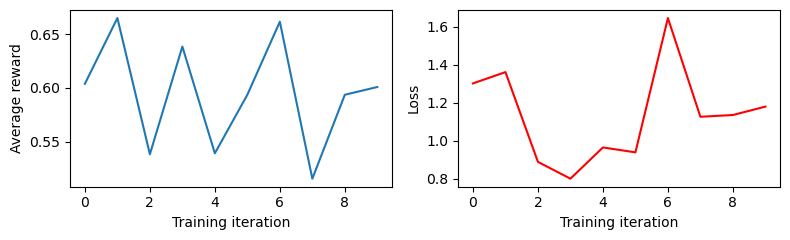

100%|██████████| 100/100 [00:02<00:00, 34.39it/s]


Sample trajectories: 100
[5.176, 5.766, 5.493, 0.010, 0.031, 0.048]    COC1=CC=C(C=C1)S(=O)(=O)N(C2=CC=CC(Cl)=C2)CC(=O)NC(C3=CC=CC=C3)C4=CC=CC=C4
[6.181, 6.355, 6.411, 0.069, 0.096, 0.268]    O=C(NC1=CC(C(F)(F)F)=CC=C1N2CCOCC2)C3CCN(CC3)S(=O)(=O)C4=CC=C(Br)C=C4
[6.569, 6.560, 5.735, 0.144, 0.142, 0.077]    CCOC1=CC=C(C=C1)S(=O)(=O)N(C2=CC=C(F)C=C2)CC(=O)NC3=CC=CC=C3C(=O)NC4CCCCC4
[7.601, 6.421, 6.312, 0.799, 0.109, 0.225]    CC(C)(C1)SC=CC(C1)C(C)C(NC2=CC=C(C=C2)OC3=CC=CC=C3)CCC=NCS4C=CCNC(=O)C5=CC=CC=C54
[4.714, 4.694, 4.265, 0.004, 0.004, 0.004]    NNCCN1CC2OCC1(C)C2C(=O)NC(=S)NC=C(O3)CC(O)CC(O4)CC(O)C(OC(C)=O)CSC(O)C3=C4OC5=CC=C(OC)C(OC)=C5
[5.419, 4.921, 5.522, 0.015, 0.006, 0.051]    CC(C)C1=CC=C(C=C1)NC(=O)COC2=CC=C(C=C2Br)C=C3C(=O)NC(=O)N(C3=O)C4=CC=C(Cl)C=C4
[6.781, 6.168, 6.998, 0.213, 0.067, 0.691]    C1CC(=O)OC2=CC3=CC=C2C(C3)=NN1CCN(C4=CC(Cl)=CC=C4C)C=O
[5.401, 5.875, 5.421, 0.015, 0.038, 0.042]    CN1C(=O)[NH1]C(=O)C=C1N=CCN2C=CC(=O)N(C3=CC=CC=C3)C(=S)N(C2=O)C4=CC=C(Br)C=C

[4.880, 4.478, 4.655, 0.005, 0.002, 0.009]    O=CCOC=CC=C(Cl)C(=CC(Br)=CO)CC=CN=CN1CCN(CC1)C2=CC=C(C=C2)[N+1](=O)[O-1]
[5.810, 5.180, 5.163, 0.034, 0.010, 0.025]    CCOC(=O)COC1=C(Cl)C=C(C=C1Br)C=C2SC(=O)N(C2=O)C3=CC=CC=C3
[5.268, 4.493, 4.656, 0.011, 0.002, 0.009]    C1CC(C)C(C(C)=C1)NC(=O)CCNC2CNC=C(C2=O)C3CCCCC3
[6.312, 6.138, 5.997, 0.089, 0.063, 0.126]    C1C2=CC=C(C=C2)CNCSCC=CC=CSC(C1=O)(C3C=CC=CC3=N)C4=CC=C(Cl)C=C4
[7.697, 6.855, 6.665, 0.910, 0.243, 0.413]    COC=C1C(SCC(=O)NC2=CC=C(Cl)C=C2)=CC=C1OCC(=O)NC3=CC(Cl)=C(Cl)C=C3Cl
[6.041, 5.575, 5.505, 0.053, 0.021, 0.049]    O=C(COC1=CC=CC2=CC=CC=C12)C=C3C=CC(Cl)C=C3Cl
[4.884, 4.737, 4.759, 0.005, 0.004, 0.011]    CCOC1=CC=CC=C1OCCCOC2=CC=C(C=C2OC)S(=O)(=O)C3=CC(F)=CC=C3[N+1](=O)[O-1]
[8.427, 7.527, 6.606, 2.000, 0.720, 0.375]    COC1=CC=C(C=C1[N+1](=O)[O-1])C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5
[5.488, 4.846, 4.855, 0.018, 0.005, 0.014]    CC=1C=NNC(=O)OCOC(=C(C)C2C=CC=1C)C(O)COP(O)(=O)CN2O
[5.309, 5.050, 5.323,

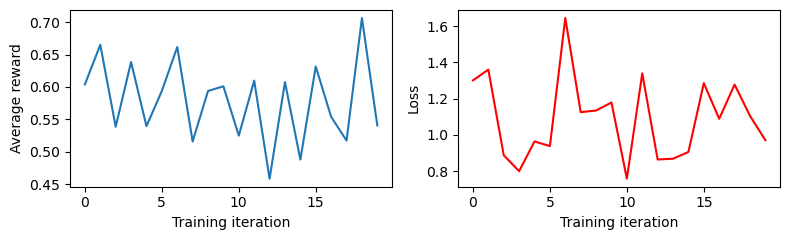

100%|██████████| 100/100 [00:02<00:00, 35.67it/s]


Sample trajectories: 100
[6.307, 5.843, 5.279, 0.088, 0.036, 0.032]    C1OC2=CC=C(C=C2)C(=O)NCCNC(=O)CN(CC1)C(=O)SC3=N[NH1]C(=N3)C4=CC=CC(=C4)[N+1](=O)[O-1]
[5.856, 6.131, 5.668, 0.037, 0.063, 0.067]    C1C2CCCCC2(C13)CN(CC=C3OCC4=CC=CC(Cl)=C4)C(=O)C5=CC=C(Cl)C(=C5)S(=O)(=O)N6CCC7=CC=CC=C7C6
[5.514, 4.681, 5.347, 0.019, 0.004, 0.036]    O=CCC1=CC=CC(=C1)S(=O)(=O)N2CCC3=CC=CC=C32
[5.608, 5.198, 5.401, 0.022, 0.010, 0.040]    C1OC=C2C=C(S(=O)(=O)N(C)C)C=C2CNC(=O)CN(C)C(=O)C(C(C)C)NC(=O)C(C)NC1=O
[6.917, 6.332, 5.808, 0.271, 0.092, 0.088]    COC1=CC=CC=C1N(S(C)(=O)=O)CC(=O)N(CC2=CC=C(Cl)C=C2Cl)C(C)C(=O)NC3CCCCC3
[5.785, 5.225, 6.050, 0.032, 0.011, 0.140]    CC1=CC=C(C=C1)NCC=CC2=CC=CC=C2NCSC3=C(CCCC3)C=O
[5.269, 5.084, 5.038, 0.011, 0.008, 0.020]    CC1=CC=C(C=C1)S(=O)(=O)N(C2=CC=CC(Cl)=C2C)CC(=O)NCCSCC3=CC=CC=C3CCl
[7.150, 7.500, 7.197, 0.403, 0.693, 0.909]    CC1=CC=CC=C1OCCNC(=O)C2=CC=C(C=C2)CN(C3=CC(Cl)=CC=C3C)S(=O)(=O)C4=CC=CC=C4
[5.989, 6.497, 6.262, 0.048, 0.126, 0.206]    C1OC2=CC

[5.408, 5.386, 5.738, 0.015, 0.014, 0.077]    O=CCOC=CC=C[NH1]CC1=CC=C(C=C1)CNC(=S)[NH1]C2=CC=C(Cl)C(Cl)=C2
[7.647, 7.998, 7.321, 0.850, 1.311, 1.065]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(F)=C5
[5.215, 5.160, 5.881, 0.010, 0.009, 0.101]    O=C(O)CC(C)OC1=CC=C(C2=C1)CCNCC=CNCCN(CC2)C(=O)C3=CC=C(C)C=C3
[5.520, 4.864, 5.241, 0.019, 0.005, 0.029]    O=C(C1=CC=C(C=C1)C2=CC=CC=C2)CCNCCC=C=CC=COC=CC=C3C4=CC=CC3N=CCO4
[6.856, 5.773, 5.522, 0.244, 0.031, 0.051]    COC1=CC=C(C(=C1)[N+1](=O)[O-1])NC(=O)NCCCCC2(CCN(CC2)CC3=CC=CC=N3)C(=O)NC(C)(C)C(O)=O
[6.631, 6.075, 6.328, 0.162, 0.056, 0.232]    CN(NC1=CC(Cl)=CC=C1OC2=CC=CC=C2)CCCC(=O)NCC3=CC=C(C=C3)C(C4=CC=CC=C4)(C5=CC=CC=C5)C6=CC=CC=C6
[7.387, 6.661, 6.161, 0.587, 0.171, 0.171]    C=1CC(N(C)N=1)CCN(CC2=CC=C(F)C=C2)CCCOC(O)=NC(=O)N(CN)CC(C)C
[6.465, 5.580, 5.483, 0.119, 0.021, 0.047]    CC=CCN=NC=CCC1C(C2=CC=CC=N2)NC(=S)N1C=CC3=C(OC(C)C)C(OC)=C3
[5.557, 5.312, 5.480, 0.020, 0.012, 0.047]    CCC(C)(C)NC(

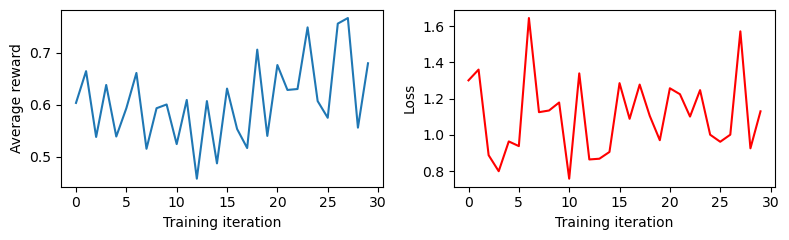

100%|██████████| 100/100 [00:02<00:00, 34.27it/s]


Sample trajectories: 100
[6.616, 5.638, 5.216, 0.158, 0.024, 0.028]    CC(C)(C)OC(=O)NC1=CC=CN=C1C2(CCC3CC2)NC=C(F)C(=O)N3CC4=CC=CC=C4
[6.236, 5.942, 6.281, 0.077, 0.043, 0.213]    CCC(C(=O)NC1CCCCC1)N(CC2=CC=C(F)C=C2)C(=O)CN(S(=O)(=O)C3=CC=CC=C3)C4=CC(=CC=C4Cl)C(F)(F)F
[6.435, 6.677, 6.599, 0.112, 0.176, 0.370]    O=C(COC1=CC=C(Br)C=C1)NC(=S)NC2=CC=C3OC(=NC3=C2)C4=CC=CC=C4Br
[6.659, 6.020, 6.178, 0.171, 0.051, 0.177]    CC(=O)N1CCC=C(C1)SCN=C(OC2=CC=CC=C2)NC(=S)NC3=CC=C(C=C3)CCCC4=CC=CC=C4
[5.870, 5.800, 6.359, 0.038, 0.033, 0.245]    CC1=CC=C2N=C(OC2=C1)C=CNN=CC=CCOCCCCC3=CC=C(Br)C=C3
[5.478, 5.956, 4.958, 0.017, 0.045, 0.017]    CCOC(=O)C1=C(C2=CC=CC=C2)N=C3SC(C(=O)N3C1C4=CC=CC(OC)=C4)=CC5=CC=C(O5)C6=CC=CC(=C6C)[N+1](=O)[O-1]
[6.827, 6.644, 6.143, 0.231, 0.166, 0.166]    CCOC1=CC=CC=C1N(S(=O)(=O)C2=CC=C(C)C=C2)CC(=O)N(C(CC)C(=O)NC)CC3=CC=C(Cl)C(Cl)=C3
[6.837, 6.557, 6.622, 0.235, 0.141, 0.385]    COC1=CC=C(C=C1Cl)N(S(=O)(=O)C2=CC=CC=C2)CC(=O)NCCS3CC=C(C=C3)C(C)(C)C
[6.187, 6.141, 5.

[4.715, 4.509, 4.887, 0.004, 0.003, 0.014]    O=CN1N=NN=C1N2CCN(CC2)CC3=NC(O)=CC(=C3O)C(O)=O
[6.274, 6.386, 5.900, 0.083, 0.102, 0.105]    CC(C)(C)C1=CC=C(C=C1)CC(=O)NCCCCCCNCCNSC(O)CC2CCCN2CN(CC3=CC=CC=C3)C(=O)C4=CC=CC=C4F
[8.069, 8.397, 7.617, 1.415, 1.948, 1.489]    C1=CC=C1NC(=O)CSC2=NN=C(N2C)C(CC(C)C)NC(=O)C3=CC=C(Cl)C(=C3)S(=O)(=O)NC4=CC=CC=C4F
[6.152, 5.028, 4.876, 0.065, 0.007, 0.014]    CCC(Cl)C1=CC=C(C=C1)OCCOC2=CC=C(C=C2)C=C3SC(=S)N(C3=O)C4=CC=CC5=CC=CC=C45
[6.762, 6.682, 7.398, 0.206, 0.178, 1.168]    CCC=NNC(N1CCCCCC1)=C(C(=O)OC)CC(=O)NC2=CC=CC=C2CC=CC(=O)N(C3=CC=CC=C3)C(=O)NC4=CC=C(Cl)C(Cl)=C4
[5.821, 5.504, 5.394, 0.034, 0.018, 0.040]    CCC(C(=O)NC(C)(C)C)N(CC1=CC=C(Cl)C=C1)C(=O)CCCN2C3=CC=CC4=CC=CC(=C34)S2(=O)=O
[6.304, 5.547, 6.064, 0.088, 0.020, 0.143]    CS(=O)(=O)N(CC1=C(Cl)C=CC=C1Cl)C2=CC=C(C=C23)C4CC5CC(C4)CC3C5
[4.622, 3.941, 4.213, 0.003, 0.001, 0.004]    COC=CC(COC(C1)=O)C(=O)NCCN1CC2=CC=CC=C2Cl
[6.090, 6.173, 6.525, 0.058, 0.068, 0.327]    CCNC(=O)C(CC1=CC=CC

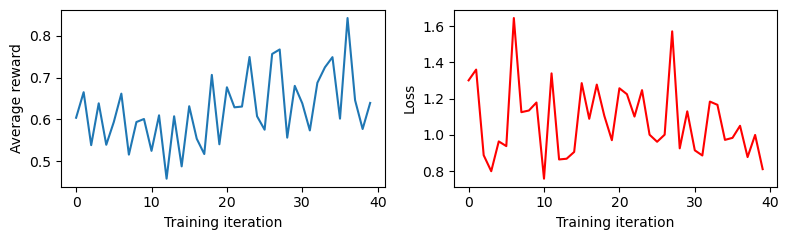

100%|██████████| 100/100 [00:02<00:00, 33.67it/s]


Sample trajectories: 100
[6.699, 6.157, 6.355, 0.184, 0.066, 0.243]    O=C(NC1=CC=C(F)C(Cl)=C1)C(NC(=O)C2=CC=CC=C2)=CC3=CC=C(O3)C4=CC=CC=C4Br
[7.563, 7.900, 7.251, 0.758, 1.172, 0.976]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[6.392, 7.380, 6.898, 0.103, 0.580, 0.596]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C(Cl)=C2)C(=O)CN(S(C)(=O)=O)C3=CC(OC)=CC=C3OC
[5.154, 3.930, 4.302, 0.009, 0.001, 0.005]    C1CC(C)C(=N1)OCCCCCCC=CC=CC=CCCCOC2OC(CO)C(O)C(O)C2O
[6.557, 6.713, 6.353, 0.141, 0.188, 0.242]    CCC(C(=O)NC(C)C)N(CC1=C(Cl)C=CC=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2C)[N+1](=O)[O-1]
[5.499, 5.351, 5.319, 0.018, 0.014, 0.034]    O=C(O)C(SC1=NN=C(O1)C2=CC=C(Cl)C=C2)=CC3=CC(Br)=CC=C3OCC4=CC=CC=C4
[5.565, 5.198, 5.564, 0.021, 0.010, 0.055]    C1C=CCCCC=NC=CC=C(C)N1C2=CC=C(C=C2)OCC3=CC=CC=C3
[7.531, 6.876, 6.296, 0.725, 0.253, 0.219]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)C3=CC=C(C(Cl)=C3)N4CCOCC4
[5.938, 6.419, 6.860, 0.043, 0.109, 0.563]  

[6.736, 6.080, 6.334, 0.196, 0.057, 0.234]    CCOC1=CC=CC(=C1)C(=O)OCC2OC(=CC=C2O)CCCCC=CC=CSCCNC=CC=C(C3C4=C5C=CS4)C=C3C(O)C(O)C5(O)COO
[6.709, 6.654, 6.592, 0.187, 0.169, 0.366]    O=C(C1=CC=CC=C1Cl)N2N=C3C(=CC4=CC=C(Br)C=C4)CCCC3C2C5=CC=C(Cl)C=C5
[5.168, 4.947, 5.196, 0.009, 0.006, 0.027]    O=C(C=1O)CNC(C(=CN=1)C(=O)OC)=CC2=NC3=CC=CC=C3C2C4=CC=CC=C4
[5.704, 5.754, 5.272, 0.027, 0.030, 0.031]    C1C(Br)=C1OCC2=CC=C(C)C(C)=C2CN3CCOCC3C4=CC(=O)SC4=CNS(=O)(=O)C5=C(C)C=C(F)C=C5F
[6.509, 5.453, 5.808, 0.129, 0.017, 0.088]    N1C=C(NC2=CC=CC=C12)CN3C(=S)NC(C4=CC=CC=N4)C3C5=CC=CN5C6=CC=CC(=C6)[N+1](=O)[O-1]
[5.514, 5.131, 5.188, 0.019, 0.009, 0.026]    O=C(N1CCN(CC1)C2=CC=C(F)C=C2)COC(=O)C3=CC=C4C(=C3)C(=O)N(C4=O)CC=CC=C5C=CC=CC5
[4.992, 5.018, 5.298, 0.007, 0.007, 0.033]    O=CCSC=CC1=CC=C(O1)C2=CC=C(Cl)C(=C2)[N+1](=O)[O-1]
[5.908, 4.920, 4.996, 0.041, 0.006, 0.018]    CCCN(CCO)CC1=CC=C(O)C(=C1)CC(O)(C)COC=CC
[6.024, 6.255, 6.104, 0.051, 0.080, 0.154]    CCOC(=O)C1=CC=CC(=C1C)NC(=O)CN(C2=

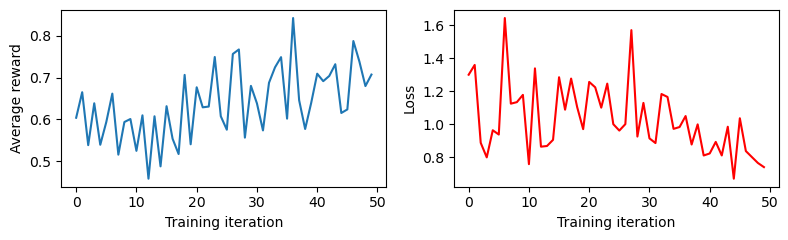

100%|██████████| 100/100 [00:02<00:00, 33.40it/s]


Sample trajectories: 100
[5.415, 5.415, 5.567, 0.015, 0.015, 0.055]    O=CN=PC1=CC=C(C=C1)C2SCC(=O)N2CC3=CC=C(Cl)C=C3
[8.087, 7.271, 6.595, 1.443, 0.490, 0.368]    CC1=CC(Br)=CC=C1NC(=O)CCN2C(=S)NC(C3=CC=CC=N3)C2C=4C=C(C)N(C=4C)C5=CC=C6C(=C5)OCO6
[6.577, 6.920, 6.269, 0.147, 0.273, 0.208]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC=C(Cl)C=C2)S(=O)(=O)C3=CC=C(OC)C=C3
[5.522, 6.041, 5.835, 0.019, 0.053, 0.093]    CC1=CC(Br)=CC=C1NC(=O)CN(C2=CC=CC(Br)=C2)S(=O)(=O)C3=CC=C(C)C=C3
[6.447, 5.435, 6.149, 0.115, 0.016, 0.168]    O=C(NC1=CC=CC2=CC=CC=C12)CSC=NN=C(C(=O)C=3SN=C(C=3N)C(N)=O)C=4SC5=CC=CC=C5C=4Cl
[6.934, 6.826, 6.513, 0.279, 0.231, 0.320]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(Cl)C=C1)C(=O)CN(S(C)(=O)=O)C2=CC(Cl)=CC(Cl)=C2
[7.088, 6.359, 5.848, 0.364, 0.097, 0.095]    CC1CCCCN1C(=O)COC(=O)C(CC2=CC=CC=C2)N3C(=O)CC(C3=O)C4(Cl)C(Cl)=C(Cl)C(OC)=C4
[5.676, 5.783, 5.812, 0.026, 0.032, 0.089]    CC1=CC=C(C=C1)S(=O)(=O)N(C2=CC=C(C)C(C)=C2)CC(=O)NCC3=CC=CC(=C3)CN4CCCCC4
[6.599, 7.357, 6.30

[5.242, 4.719, 4.548, 0.011, 0.004, 0.007]    C1COC(=O)C(CCCOC)CNC(=O)CCCNN1CCCN2C(=O)C3=CC(O)=CC=C3C2
[5.836, 5.546, 5.624, 0.035, 0.020, 0.062]    O=CCCCCOC(=O)C1=CC=C(C=C1)C(=O)NCCCCCCC2OC=CC=CC3=CC=CC=C2NCSCC4C=CN[NH1]C4=C3
[5.889, 6.254, 5.635, 0.039, 0.079, 0.063]    CCC(C(=O)NC1CCCC1)N(CC2=CC=CC=C2)C(=O)CN(C3=CC=C(Cl)C=C3C)S(=O)(=O)C4=CC=C(C)C=C4
[5.524, 5.069, 5.183, 0.019, 0.008, 0.026]    O=C(NC1=CC=C(C=C1)S(=O)(=O)N2CCCCC2)C3=CC=CC(=C3)C=CC=CC=CC4=CCCCCC4
[7.108, 8.502, 6.348, 0.376, 2.131, 0.240]    CCCC=C(C(=O)OCC)C(C1=C(OC)C=CC2=CC=CC=C12)N3C(=N)SC(C3=O)=CC4=CC=C(O4)SC5=NC=CC=N5
[6.367, 6.989, 6.302, 0.099, 0.307, 0.221]    CCC(C(=O)NC1CCCCC1)N(CC2=CC=C(Cl)C=C2)C(=O)CN(S(C)(=O)=O)C3=CC=C(F)C(F)=C3
[6.586, 6.244, 6.729, 0.149, 0.078, 0.458]    O=CC(C(=O)NCC1=CC=C(Cl)C2=C1)C(=O)N(C3=CC=C(Cl)C=C3)C(=O)N(C2=O)C4=CC=CC5=CC=CC=C45
[5.320, 5.236, 5.328, 0.013, 0.011, 0.035]    O=C(C1=CC=CC=C1CC2CCCCC2)NC3=CC=C4N=C(SC4=C3)SC5=CC=C(Cl)C=C5
[6.228, 5.734, 5.361, 0.076, 0.029, 0.037

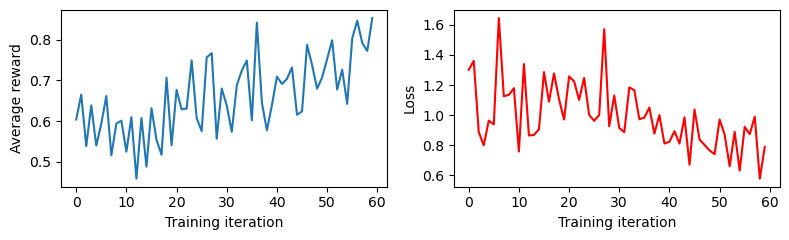

100%|██████████| 100/100 [00:02<00:00, 33.50it/s]


Sample trajectories: 100
[7.191, 6.451, 6.164, 0.431, 0.116, 0.172]    C1N=C(O)C(OC(=O)C2=CC=CC=C2)C1OC3=CC=C(C=C3)CNC(=S)NC4CCCCC4CC
[5.622, 5.494, 5.634, 0.023, 0.018, 0.063]    O=C(NC1CCC2CC1)C(CC3=CC=CC=C3)N(CC4=CC=CC(Cl)=C4)C(=O)N2
[4.382, 4.113, 4.462, 0.002, 0.001, 0.006]    N1=CC=C1OC(C2)C(CCCC2)C=CC(N3CCOCC3)C=CC4=CC=C(C=C4[N+1](=O)[O-1])S(=O)(=O)N5CCCCC5
[8.789, 8.853, 7.491, 2.650, 2.771, 1.300]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C=C5Cl
[5.279, 4.901, 5.404, 0.012, 0.006, 0.040]    O=CNCCN1CCN(CC1)C(C2=CC=CC=C2)C3=CC=CC=C3
[4.320, 3.804, 4.417, 0.002, 0.001, 0.006]    CCOC=CCBr
[6.234, 6.695, 6.053, 0.076, 0.182, 0.140]    COC1=CC=CC=C1NC(=S)C2=C(C3=CC=C(Cl)C=C3)C4=C5N(CCCC4)C(=CN25)C6=CC=CC=C6
[6.609, 5.852, 5.585, 0.156, 0.036, 0.057]    CCCCN1C(=O)N=C(O)C2=C1N=C(C2=O)C(C(=O)NCCC3=CC=CC(Cl)=C3)=C4C=CC([NH1]4)OCCCC(O)=O
[6.872, 6.978, 6.057, 0.251, 0.301, 0.141]    O=CCC(C=O)N(CC1=CC=CC(Cl)=C1)C(=CC(Br)=COCC2=CC=C(F)C=C2)C3=CC(

[6.567, 6.727, 5.822, 0.144, 0.193, 0.090]    CCOC(=O)C1=CC=C(C(Cl)=C1)NC(=O)CN(C2=CC=C(Br)C=C2)S(=O)(=O)C3=CC(C)=CC=C3OC
[6.539, 5.832, 5.854, 0.136, 0.035, 0.096]    CC1=CC=C(C(Br)=C1)N2C(C)=CC(=O)NC2C(=O)C=CC=C(C3=NN=NN3C4CCCCC4)C5=CC=C(C=C5)C(C)(C)C
[6.304, 6.548, 6.118, 0.088, 0.139, 0.158]    CCC(C)NC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC=C(OC)C(Cl)=C2
[6.053, 5.399, 6.123, 0.054, 0.015, 0.160]    O=CSCN(C1=CC=C(Cl)C=C1Cl)S(=O)(=O)C2=CC=CC=C2
[6.790, 6.580, 6.119, 0.216, 0.148, 0.158]    COC1=CC=CC=C1NC(=O)CCN2C(=O)C3C(C2=O)C4(Cl)C5=CC=CC=C5C3(Cl)C6=CC=CC=C64
[6.285, 5.625, 5.495, 0.084, 0.023, 0.048]    CNS(=O)(=O)C1=CC=C(C=C1)NCC(=O)N(CC2=CC=C(F)C=C2)C(C3=CC=C(Cl)C=C3)C(=O)NC4CCCCC4
[6.970, 6.794, 6.906, 0.298, 0.218, 0.603]    CC1=CC=C(C=C1)C=CC=C(CC2=CC=C(Cl)C(Cl)=C2)CC=CC(NC3=CC=C(C4=C3)S(=O)(=O)N5CCCC5)=CC(=N4)S(=O)(=O)C=CC=C(Cl)N=NC6=CC(Cl)=CC=C6Cl
[7.148, 7.222, 6.862, 0.402, 0.454, 0.564]    CCC(C(=O)NC(C)(C)C)N(CC1=CC=CC=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(Cl)=

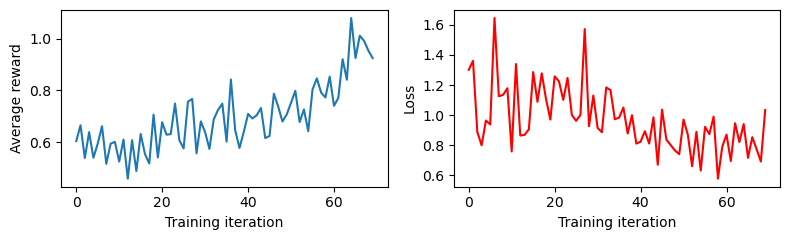

100%|██████████| 100/100 [00:02<00:00, 35.12it/s]


Sample trajectories: 100
[7.156, 6.907, 6.670, 0.407, 0.266, 0.416]    C(=[NH1])CCNS(=O)(=O)C=CC=CC(C1=CC=C2C=CC=C3C2=C1)(C(=O)N3CC4=CC=C5C(=C4)OCO5)C6=CC=CC(=C6)C(F)(F)F
[5.447, 5.485, 5.566, 0.016, 0.018, 0.055]    CC1=CC(Br)=CC=C1N2C(=O)NC(=O)C(C2=O)=CC3=CC=C(C(Cl)=C3)OCC4=CC=CC=C4
[5.637, 5.423, 5.547, 0.024, 0.016, 0.053]    CC1=CC=C(C=C1)CC=2CN3C=C(Cl)CC=C3C(=O)C=2C=C4SC(=S)N(C4=O)NC5CCCC5C(=O)OCC6=CC=CC=C6
[7.078, 7.104, 6.999, 0.358, 0.374, 0.692]    O=C(C1=CC=C(Br)C=C1)NC(=S)NC2=CC=C3OC(=NC3=C2)C=CC=C4C=C(Cl)CC=C4Cl
[8.043, 6.824, 6.243, 1.377, 0.230, 0.199]    CCC(C(=O)NC1CCCCC1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(S(=O)(=O)C3=CC=CC=C3)C4=CC(=CC=C4Cl)C(F)(F)F
[6.300, 5.000, 5.198, 0.087, 0.007, 0.027]    CCOC(=O)C(C1=CC2=CC=C1)(N3CCC4CC3)CC=C4OCC(=C2)CCNCC5=NOCC(=O)C5OC
[6.152, 5.319, 5.855, 0.065, 0.013, 0.096]    CC(C(=O)NC1CCCCC1)N(CC2=CC=C(Cl)C=C2Cl)CN(CC3=CC=CC=C3)C(=O)CCN4C(=O)CC4=C
[6.481, 6.525, 6.287, 0.122, 0.133, 0.215]    O=C(NC1=CC=C2C(=C1)OCCO2)COC3=CC=C(C=C3Br)C=C4NC(=

[7.173, 8.138, 6.765, 0.418, 1.522, 0.486]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC=C5Br
[5.948, 6.286, 6.568, 0.044, 0.085, 0.352]    C1CCNC(SCC(=O)NC2=C(C)C=C(C)C=C2C)N3C=C(CC=C31)S(=O)(=O)C4=CC=C(C)C(C)=C4
[6.915, 6.840, 6.286, 0.270, 0.237, 0.215]    CCC(C(=O)NC1CCCCC1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(S(C)(=O)=O)C3=CC(OC)=CC=C3OC
[8.454, 8.529, 7.444, 2.046, 2.178, 1.232]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC=C(Cl)C5Cl
[5.860, 5.843, 5.279, 0.037, 0.036, 0.031]    COC(=O)C=C(C)N(C1=CC=C(OC)C(Cl)=C1)C(=O)C=CC2=CC=C(O2)CN3C(=O)SC(C3=O)C4=CC=CC=C4F
[5.768, 6.330, 5.849, 0.031, 0.092, 0.095]    COC1=CC=C(C(OC)=C1)N2C(=O)NC(=O)C(C2=O)=CC3=CC(Br)=CC(Br)=C3OCC(=O)NC4=CC=C(Cl)C(Cl)=C4
[5.844, 5.291, 6.407, 0.036, 0.012, 0.267]    O=C(CC)C1CCCN(C1)S(=O)(=O)CC2=CC=C(Cl)C(Cl)=C2
[5.352, 5.299, 5.404, 0.014, 0.012, 0.040]    O=CCOC=CC=C[NH1]CC1=CC=C(C=C1)S(=O)(=O)N2CCC(C)CC2
[5.140, 5.260, 5.860, 0.009, 0.011, 0.097] 

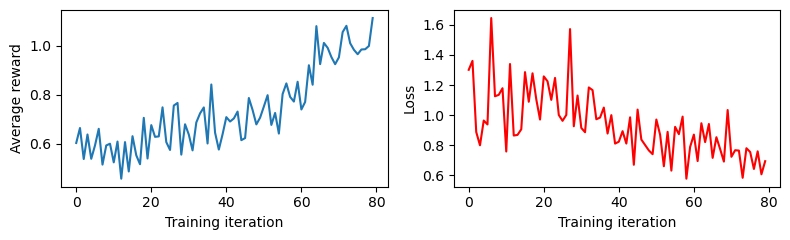

100%|██████████| 100/100 [00:02<00:00, 36.16it/s]


Sample trajectories: 100
[8.301, 8.194, 7.456, 1.785, 1.610, 1.250]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(C=C5Cl)C6=CC=CC=C6
[5.835, 5.309, 6.005, 0.035, 0.012, 0.128]    CCCCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC=CC(=C2)C(F)(F)F
[8.127, 8.637, 7.769, 1.505, 2.371, 1.733]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC=C(Cl)N5
[7.563, 7.900, 7.251, 0.758, 1.172, 0.976]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[6.476, 5.808, 5.760, 0.121, 0.033, 0.080]    COC=CC(C1=CC=C(C=C1)S(=O)(=O)C2=CC=C(C=C2)C(C)C)=C(Br)C=COCC(=O)NC3=CC=CC=C3Cl
[6.416, 6.842, 6.600, 0.108, 0.238, 0.371]    COC(=O)C1=C(C)N(CC2=CC=C(C)C=C2)C(=O)C1=CC3=CC=C(O3)CN(CC4=CC=C(Cl)C=C4Cl)S(=O)(=O)C5=CC=CC=C5
[7.173, 8.138, 6.765, 0.418, 1.522, 0.486]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC=C5Br
[6.054, 5.815, 5.413, 0.054, 0.034, 0.041]    O=C(NC1=CC=CC(

[6.056, 6.082, 6.664, 0.054, 0.057, 0.412]    CC1=CC=C(C=C1S(=O)(=O)N2CCN(C)CC2)C3=NN=C(C4=CC=CC=C34)NC5=CC(Cl)=CC=C5OC6=CC=CC=C6
[5.138, 5.496, 5.721, 0.009, 0.018, 0.075]    CCCCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C)S(=O)(=O)C2=CC=C(Cl)C=C2
[8.575, 8.985, 7.587, 2.260, 3.021, 1.444]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5
[7.016, 8.000, 7.357, 0.322, 1.313, 1.112]    CCCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(S(C)(=O)=O)C3=CC(=CC=C3Cl)C(F)(F)F
[8.224, 8.840, 7.757, 1.658, 2.746, 1.712]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Cl)=C5Cl
[5.055, 4.270, 5.452, 0.007, 0.002, 0.044]    CNC=C[NH1]CC(=O)C1=CC=CC(=C1)S(=O)(=O)N2CCC3=CC=CC=C3C2
[7.019, 6.775, 6.224, 0.324, 0.211, 0.192]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC3=CC=C(C(Cl)=C3)N4CCN(CC4)C(=O)CC
[6.624, 6.540, 5.879, 0.160, 0.137, 0.101]    O=COCC=CC=C1C=CC=CC1NC2=CC=C3OC(=NC3=C2)C4=CC=CC5=C(Cl)C=CC=C45
[8.454, 8.529, 7.4

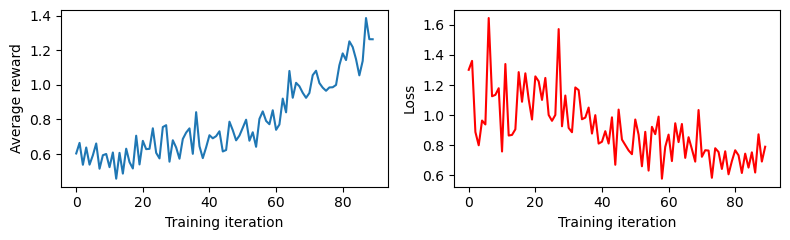

100%|██████████| 100/100 [00:02<00:00, 37.25it/s]


Sample trajectories: 100
[8.224, 8.840, 7.757, 1.658, 2.746, 1.712]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Cl)=C5Cl
[8.546, 9.083, 7.686, 2.208, 3.207, 1.599]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5Cl
[8.224, 8.840, 7.757, 1.658, 2.746, 1.712]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Cl)=C5Cl
[7.050, 7.206, 6.970, 0.341, 0.442, 0.663]    CCC(C(=O)NC(C)C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[8.331, 8.095, 7.141, 1.836, 1.455, 0.844]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=C5C=C(Cl)CC=C5Cl
[6.649, 6.899, 5.945, 0.167, 0.263, 0.115]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)CC5=CC=CO5
[6.116, 5.596, 5.390, 0.061, 0.022, 0.039]    C1COC2=CC=C(C=C2)N(S1)S(=O)(=O)C3=CC=C(C=C3)OCC4=CC=CC=C4
[6.930, 7.290, 7.275, 0.277, 0.505, 1.005]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(Cl)C=C1Cl)

[5.799, 5.473, 5.828, 0.033, 0.017, 0.092]    C1COC=CC(C(=O)NC2(C)C)(CC=C21)OC3=CC=C(Cl)C=C3[N+1](=O)[O-1]
[5.825, 5.571, 5.832, 0.034, 0.021, 0.092]    O=COCCCOCCN(CC1=C(F)C=CC=C1Cl)S(=O)(=O)C2=CC=C(Cl)C=C2
[6.026, 6.011, 5.897, 0.051, 0.050, 0.105]    O1CC2=CC(=CC2=C1)C(=O)NCCC(C)(C(=O)NCC3CC4CO3)N=CSCOCC=CC=CC(=O)N4CCOC
[6.799, 7.517, 6.954, 0.220, 0.710, 0.648]    CCCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=CC(Br)=C2)C(=O)CN(S(C)(=O)=O)C3=CC(=CC=C3Cl)C(F)(F)F
[6.072, 5.763, 6.244, 0.056, 0.031, 0.199]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C)S(=O)(=O)C3=CC(C)=CC=C3OCC
[7.757, 7.113, 6.306, 0.983, 0.379, 0.223]    NC(=O)CC(C1=CC=C2C(=C1)OCCO2)NC(=O)C3=CC=CC=C3OCCNC(=O)CCCOC4=CC=CC=C4NC(=O)COC5=CC=CC(OC)(CC5)O
[4.933, 4.203, 4.505, 0.006, 0.001, 0.007]    O=C(C(=O)NC1=CC=CN=C1)C2=CC(=CC=C2N3CCOCC3)S(=O)(=O)N4CCOCC4
[6.489, 6.921, 6.451, 0.124, 0.273, 0.288]    CCC(C(=O)NC1CCCCC1)N(CC2=CC=CC=C2C)C(=O)CN(S(C)(=O)=O)C3=CC(=CC=C3Cl)C(F)(F)F
[8.331, 8.625, 7.760, 1.835, 2.350, 1.718]

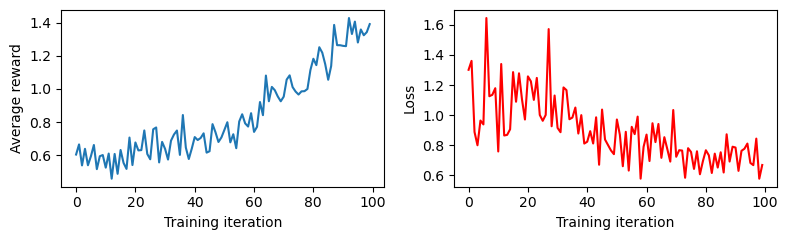

100%|██████████| 100/100 [00:02<00:00, 39.31it/s]


Sample trajectories: 100
[6.036, 5.345, 5.751, 0.052, 0.013, 0.079]    COC1=CC=C(OC2)C(=C1)S(=O)(=O)NCC(S)(CCC3=CCCCC3)CC(S(N)(=O)=O)CCNC2=O
[6.458, 6.248, 5.696, 0.117, 0.079, 0.071]    CNC(=O)C1=CC=C2C(=O)N(C3=CC=CC(Cl)=C3)C(=NC2=C1)NC(=O)C4=CC(OCC)=CC=C4[N+1](=O)[O-1]
[6.486, 6.833, 5.947, 0.124, 0.234, 0.115]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC3=CC=C(C=C3)NC(=S)NC(=O)C4=CC(Br)=CC=C4
[5.926, 6.398, 5.856, 0.042, 0.105, 0.097]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC=CC=CN=C=C3SC(=S)N(C3=O)CCCCCC(=O)NC4=CC=CC(Cl)=C4C
[7.016, 7.524, 6.937, 0.322, 0.718, 0.632]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)CCOC5=C6C=CC=C5C6C(N)=O
[8.071, 8.343, 7.896, 1.419, 1.857, 1.947]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Cl)=C5
[4.879, 4.797, 5.174, 0.005, 0.004, 0.026]    O=C(C1=CC=CS1)NCCCCCCNCCC2=C3C=C(C=C2)OCC=C=C3
[7.554, 7.930, 7.158, 0.748, 1.213, 0.863]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1

[6.648, 6.313, 6.378, 0.167, 0.089, 0.253]    O=CC1CCOCC1NC2=NC3=C(S2)CC(CC3)NC(=O)C4=CC=CC=C4F
[8.071, 8.343, 7.896, 1.419, 1.857, 1.947]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Cl)=C5
[8.546, 9.083, 7.686, 2.208, 3.207, 1.599]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5Cl
[7.414, 7.708, 6.225, 0.611, 0.922, 0.192]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=C(Cl)C(=O)[NH1]5
[7.421, 7.188, 7.257, 0.617, 0.429, 0.982]    CC(C)CCOC1=CC=C(C=C1Br)C=C2C(=O)NC(=O)N(C2=O)C3=CC=C(C=C3)C45CC6CC(C4)CC(C6)C5
[8.331, 8.625, 7.760, 1.835, 2.350, 1.718]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5
[8.383, 8.770, 7.669, 1.924, 2.615, 1.570]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC=C(Br)C5
[8.454, 8.529, 7.444, 2.046, 2.178, 1.232]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C

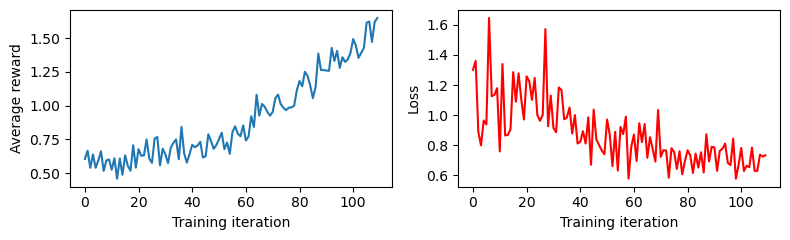

100%|██████████| 100/100 [00:02<00:00, 40.45it/s]


Sample trajectories: 100
[8.115, 8.449, 7.748, 1.487, 2.037, 1.698]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=C(F)C(F)=C(Br)C(F)=C5F
[6.999, 7.290, 6.649, 0.313, 0.505, 0.403]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C=C5Br
[8.615, 9.111, 7.745, 2.331, 3.260, 1.692]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Cl)=C5F
[8.253, 8.586, 7.676, 1.706, 2.279, 1.581]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CN=CC(Br)=C5
[6.292, 5.268, 5.395, 0.086, 0.011, 0.040]    C1OCC(=O)CN1C(C)C(C(=S)N=CO)NC(=O)CN(C)C(=O)C(CC2=CC=CC=C2)NC(=O)C(C3=CC(OC)=C(OC)C(OC)=C3)CCN(CC)CC(N)=O
[8.235, 7.497, 7.042, 1.677, 0.690, 0.736]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=C(O)C(Cl)=CBr
[4.541, 3.966, 4.641, 0.003, 0.001, 0.009]    O=C(CC(=C)[N+1](=O)[O-1])NC1=CC=CC=C1C(=O)NCCC(=O)NC(C2=CC=C(C)C=C2)C3=CC=CC=C3
[6.192, 6.256, 6.604, 0.071

[8.071, 8.343, 7.896, 1.419, 1.857, 1.947]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Cl)=C5
[8.115, 8.495, 7.199, 1.487, 2.118, 0.912]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(Cl)=CC=C2Cl
[5.323, 4.449, 5.213, 0.013, 0.002, 0.028]    C1CNC(CSC2=CC=CC=C2)=NN=C1C(CC(C)C)NC(=O)C3=CC=CC=C3Br
[7.939, 8.472, 7.722, 1.226, 2.077, 1.656]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC=C(Cl)C5
[8.224, 8.840, 7.757, 1.658, 2.746, 1.712]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Cl)=C5Cl
[7.805, 8.200, 7.524, 1.043, 1.621, 1.349]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(F)=C5F
[5.897, 5.365, 6.143, 0.040, 0.014, 0.166]    O=C(CC(N)=O)CN1CC2CC(C1)C=CC(=O)C2C3=NC4=CC=CC=C4S3
[6.678, 7.097, 6.896, 0.177, 0.369, 0.595]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C(C5=CC=CC=C5)C6=CC=CC=C6[N+1](=O)[O-1]
[8.33

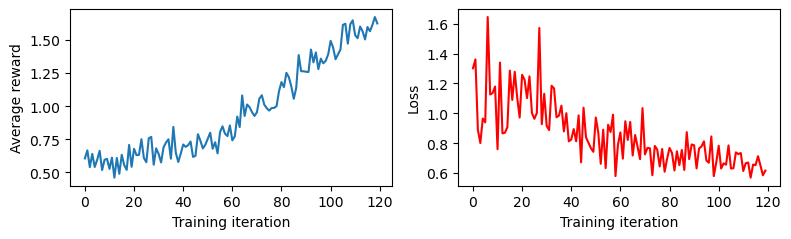

100%|██████████| 100/100 [00:02<00:00, 37.50it/s]


Sample trajectories: 100
[6.170, 5.750, 5.648, 0.068, 0.030, 0.065]    CC1CC(C)CN(C1)C2=CC=C(C(C)=C2)NC(=O)CSC3=NN=C(N3CC)C(C(C)C)NC(=O)C4=CC=CC=C4Cl
[7.950, 7.347, 6.628, 1.241, 0.552, 0.389]    CNC(=O)C(CC1=CC=CC=C1)N(C2CCCC2)C(=O)CN(S(C)(=O)=O)C3=CC(=CC=C3Cl)C(F)(F)F
[8.432, 8.569, 8.014, 2.008, 2.249, 2.151]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(F)=C5F
[5.602, 5.051, 5.185, 0.022, 0.007, 0.026]    CC(=O)N1C(C)(CC=N1)C2=CC=CC=C2NNCCCOC(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5
[6.347, 7.069, 6.250, 0.095, 0.352, 0.202]    CCNCC(=O)NCCN(C1=CC=C2C=CC=CC2=C1)SCC3=CC=C(F)C(F)=C3OCC4=CC=CC(=C4)OC5=CC=CC(=C5)N6CC(CC6=O)C(=O)NC7=CC(Cl)=CC=C7Cl
[8.891, 9.242, 7.655, 2.842, 3.515, 1.548]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5Br
[5.075, 5.363, 5.312, 0.008, 0.014, 0.034]    NC1=NC(=CS1)CCC(=O)C2CNN=C(CC3=CC=C(Cl)C=C3)C(=O)C4=CC=CC=C4N2
[8.361, 8.832, 7.497, 1.886, 2.731, 1.308]    O=C(C1=CC=C(N2CCOCC2)

[8.071, 8.343, 7.896, 1.419, 1.857, 1.947]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Cl)=C5
[8.575, 8.985, 7.587, 2.260, 3.021, 1.444]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5
[8.433, 8.667, 7.583, 2.011, 2.427, 1.437]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C=C5F
[7.515, 7.813, 6.776, 0.708, 1.055, 0.494]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(O)C(Br)=C5OCC6=CC=CC7=CC=CC=C67
[7.267, 7.625, 7.025, 0.487, 0.825, 0.719]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C35)C=CC=C(Cl)C5
[8.273, 8.731, 7.813, 1.739, 2.543, 1.806]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Br)=C5
[6.241, 6.259, 6.189, 0.078, 0.080, 0.180]    CCNC(=O)C(CC)N(CCC1=CC=CC=C1)C(=O)CN(S(C)(=O)=O)C2=CC=C(C=C2)C34CC5CC(C3)CC(C5)C4
[3.047, 2.689, 3.439, 0.000, 0.000, 0.001]    CC1=CC=CC(=C1)

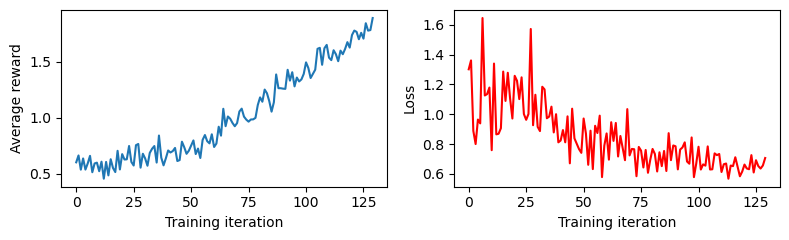

100%|██████████| 100/100 [00:02<00:00, 36.79it/s]


Sample trajectories: 100
[5.049, 4.985, 5.180, 0.007, 0.007, 0.026]    O=CCCC=CCC1=CC=CC(=C1)CCC(=O)N2CCN(CC2)C3=CC=C(Cl)C=C3F
[8.891, 9.242, 7.655, 2.842, 3.515, 1.548]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5Br
[2.903, 2.696, 3.003, 0.000, 0.000, 0.000]    C=1C=C=1
[8.508, 8.444, 7.428, 2.141, 2.028, 1.210]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC=C(Br)C5F
[7.137, 6.005, 5.974, 0.395, 0.049, 0.121]    N1C=C1C(=O)NCNCCSC(=O)OCCNC(=O)C=C2C3=CC=C(C=C3)C=C2Br
[8.575, 8.985, 7.587, 2.260, 3.021, 1.444]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5
[8.575, 8.985, 7.587, 2.260, 3.021, 1.444]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5
[8.073, 8.877, 7.694, 1.422, 2.816, 1.611]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CN=CC(Cl)=C5S
[5.708, 5.884, 5.219, 0.027, 0.039, 0.028]    CCOC

[7.171, 7.607, 6.900, 0.417, 0.806, 0.598]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=C4C=C5OC(=NC5=C3)C=CC(Cl)=C(N4)[N+1](=O)[O-1]
[8.437, 8.817, 7.639, 2.016, 2.703, 1.524]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Cl)=C5Br
[6.069, 6.417, 6.516, 0.056, 0.108, 0.322]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CCCN(S(C)(=O)=O)C3=CC=CC(Cl)=C3
[6.388, 7.526, 5.936, 0.103, 0.719, 0.112]    COC(=O)C1=CC(=CC=C1OCC2=CC=CC=C2)CC(CC(=O)N3CCOCC3)C=CC([N+1](=O)[O-1])=NC(C(=O)OC)=CC4=CC=C(OC)C(=C4)OCC56N7N=C(C8=CC=CC=C8)C(C7)=NN5C6C9=CC=CC(OC)=C9OCC
[7.601, 7.939, 6.265, 0.799, 1.225, 0.207]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(OC)C(Br)=C5
[4.846, 4.028, 4.596, 0.005, 0.001, 0.008]    O=C(C1=CC=C(N2CCOCC23)C(=C1)[N+1](=O)[O-1])NC4=NCCCN43
[7.824, 8.302, 7.424, 1.068, 1.788, 1.205]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC(Cl)C=C5
[8.284, 8.206, 7.396, 1.75

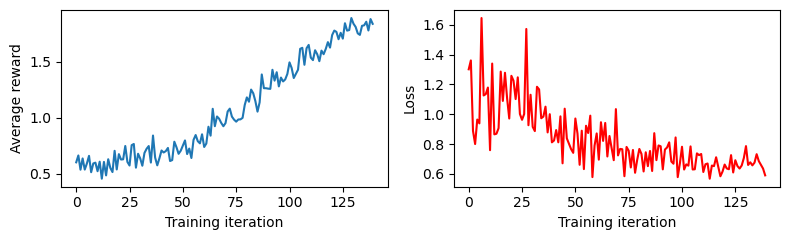

100%|██████████| 100/100 [00:02<00:00, 38.35it/s]


Sample trajectories: 100
[7.082, 6.863, 6.606, 0.360, 0.247, 0.375]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)NCCCNC(=O)C5=CC(=CC=C5Cl)[N+1](=O)[O-1]
[5.666, 5.674, 5.768, 0.025, 0.026, 0.082]    CC1=CC=CC(=C1)OC=CC(=N)NC(=O)C2CCN(CC2)S(=O)(=O)CC3=CC=C(Cl)C(=C3)C(F)(F)F
[8.680, 7.967, 7.155, 2.451, 1.265, 0.860]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC4=C5OC(=NC5=C3)C=CC=C(Cl)C=CC(C4)[N+1](=O)[O-1]
[8.748, 9.014, 7.628, 2.575, 3.075, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)S5
[8.477, 8.069, 7.172, 2.087, 1.416, 0.880]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=C(Cl)C5=NC(C6=CC=CC=C6)=C5CCl
[7.763, 7.336, 6.783, 0.991, 0.542, 0.500]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=CC=C(Br)CBr
[5.544, 5.980, 5.975, 0.020, 0.047, 0.121]    O=C(C1=CC=CC=C1)C=CC(C2=CC(Br)=CC3=C2OC)=CC(C=CC3=C)C(=C)NCC4=CC=CC=N4
[6.177, 6.449, 5.512, 0.069

[6.294, 6.094, 6.268, 0.086, 0.058, 0.208]    CCCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC=C(F)C(Cl)=C2)S(=O)(=O)C3=CC=CC=C3
[7.912, 8.147, 6.947, 1.188, 1.536, 0.641]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C35)C=CC=C(O)C5=CCCl
[5.382, 5.227, 5.825, 0.014, 0.011, 0.091]    O=C(N(CC1=CC=CC=C1)CC2=CC=CC=C2)C3=CC=C(C=C3)CN4CCN(CC4)S(=O)(=O)C5=CC=CC=C5
[8.615, 9.111, 7.745, 2.331, 3.260, 1.692]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Cl)=C5F
[8.575, 8.985, 7.587, 2.260, 3.021, 1.444]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5
[8.374, 8.839, 7.849, 1.909, 2.745, 1.867]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Cl)=C5[N+1](=O)[O-1]
[8.454, 9.027, 7.810, 2.047, 3.100, 1.801]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C=C5F
[5.947, 5.017, 5.838, 0.044, 0.007, 0.093]    O=COCC1=CC=C2C(=C1)C(=O

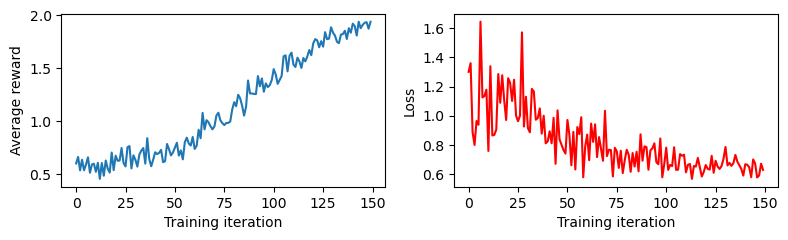

100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Sample trajectories: 100
[8.553, 8.577, 7.328, 2.221, 2.264, 1.074]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(O)C(Br)=C5
[8.748, 9.014, 7.628, 2.575, 3.075, 1.507]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)S5
[7.903, 8.245, 7.259, 1.175, 1.694, 0.985]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)CC5=CN(N=N5)C6=CC=CC(Cl)=C6Cl
[8.517, 9.151, 7.647, 2.158, 3.339, 1.536]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Br)=C5F
[7.535, 8.231, 7.051, 0.729, 1.670, 0.745]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC(Cl)=CC=C5O
[8.334, 8.240, 7.829, 1.840, 1.685, 1.832]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CN=CC(Br)=C5F
[7.810, 8.383, 7.230, 1.051, 1.924, 0.949]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)S5
[8.130, 8.507, 7.445, 1.510, 2.140, 1.234]   

[8.473, 8.912, 7.833, 2.079, 2.882, 1.840]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5Br
[8.500, 9.019, 7.856, 2.127, 3.085, 1.877]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Cl)=C5
[6.484, 6.332, 5.127, 0.123, 0.092, 0.023]    CCOC1=CC=C(C=C1S(=O)(=O)N2CCCCC2)NC(=O)C3=CC=CC=C3S(=O)(=O)C4=CC=CC=C4
[8.781, 9.040, 7.654, 2.636, 3.126, 1.547]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5F
[6.948, 7.499, 6.993, 0.286, 0.692, 0.686]    CCCCNC(=O)C(C)N(CC1=CC=CC(Cl)=C1)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC=CC=C3
[5.396, 5.182, 4.927, 0.015, 0.010, 0.016]    O=S(=O)(C1=CC(Cl)=CC=C1Cl)PN=C2C=CC(C)=CN2C=O
[5.710, 5.162, 5.132, 0.027, 0.009, 0.024]    C1OC=CC(O1)C=CC(=N)NC(C)C(=O)NC2=CC=C(OC)C=C2
[7.092, 7.152, 6.769, 0.366, 0.405, 0.488]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)CSCC5=CC=CC=C5F
[8.575, 8.985, 7.587, 2.260, 3.021, 1.444]

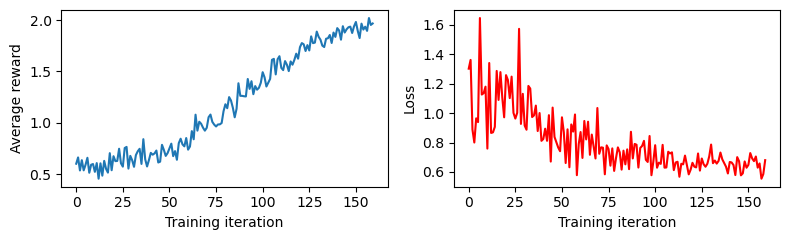

100%|██████████| 100/100 [00:02<00:00, 41.33it/s]


Sample trajectories: 100
[8.454, 8.529, 7.444, 2.046, 2.178, 1.232]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC=C(Cl)C5Cl
[8.736, 8.996, 7.603, 2.552, 3.042, 1.468]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C=C5F
[8.461, 8.489, 7.709, 2.058, 2.108, 1.635]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=C(F)C(F)=C(F)C(F)=C5F
[6.591, 7.184, 6.388, 0.151, 0.426, 0.258]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C35)C=CC=C([N+1](=O)[O-1])C(=C5)[N+1](=O)[O-1]
[8.224, 8.840, 7.757, 1.658, 2.746, 1.712]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Cl)=C5Cl
[7.929, 8.677, 7.642, 1.212, 2.444, 1.528]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Cl)=C5
[8.454, 9.027, 7.810, 2.047, 3.100, 1.801]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C=C5F
[7.005, 7.508, 6.

[8.852, 8.914, 7.014, 2.769, 2.886, 0.707]    CC=NCSC=C(NC1=NC2=CC=C(Br)C=C2S1)C=CC=CC(OCC3=CC=CC=C3)=C(C4=CC=C(C=C4)OC(C)=O)N(C5=CC=CC6=C5)C=CC(Cl)=C(SC=N6)CC7CCCCC7[N+1](=O)[O-1]
[7.817, 7.414, 6.637, 1.059, 0.611, 0.395]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=CC=C(Cl)NNC5=CC=CC(C)=C5CCl
[8.253, 8.586, 7.676, 1.706, 2.279, 1.581]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CN=CC(Br)=C5
[8.694, 9.009, 7.844, 2.475, 3.066, 1.858]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5F
[8.694, 9.009, 7.844, 2.475, 3.066, 1.858]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5F
[7.219, 8.082, 7.320, 0.451, 1.436, 1.064]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(C=C5)NC6=CC=CC=C6
[6.305, 6.980, 6.381, 0.088, 0.303, 0.254]    CCCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=CC=C2F)C(=O)CN(C3=CC(Cl)=CC=C3Cl)S(=O)(=O)C4=CC=CC=C4
[8.615,

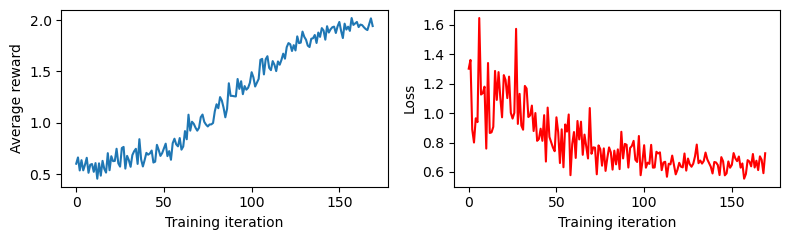

100%|██████████| 100/100 [00:02<00:00, 37.10it/s]


Sample trajectories: 100
[7.810, 8.383, 7.230, 1.051, 1.924, 0.949]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)S5
[8.517, 9.151, 7.647, 2.158, 3.339, 1.536]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Br)=C5F
[8.395, 8.395, 7.441, 1.945, 1.945, 1.228]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CN=CC(Cl)=C5F
[8.891, 9.242, 7.655, 2.842, 3.515, 1.548]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5Br
[8.694, 7.952, 6.911, 2.475, 1.244, 0.608]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=C5C=C(Br)CC=C5[N+1](=O)[O-1]
[5.207, 5.339, 5.090, 0.010, 0.013, 0.022]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=O)NC=3SC4=C(CCCC4)C=3C(N)=O
[5.856, 5.608, 5.320, 0.037, 0.022, 0.034]    O=C(NC1CCCC1)C(CC2=CC=CC=C2)N(CC3=CC=CC=C3)C(=O)CN(S(C)(=O)=O)C4=CC(=CC=C4Cl)C(F)(F)F
[7.670, 8.398, 7.726, 0.878, 1.950, 1.662]   

[7.200, 7.787, 6.652, 0.437, 1.021, 0.404]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC(Cl)=CC=C5OC6=CC=CC=C6F
[8.410, 8.645, 7.467, 1.970, 2.386, 1.265]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC=C(Cl)C5NC6=CC=CC=C6[N+1](=O)[O-1]
[8.383, 8.770, 7.669, 1.924, 2.615, 1.570]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC=C(Br)C5
[6.159, 6.446, 5.505, 0.066, 0.115, 0.049]    COC1=CC(=CC(Cl)=C1OCC2=CC=CC3=CC=CC=C23)C=C4C(=O)N(C5=CC=CC=C5)C(=O)N(C4=O)C6=CC=CC=C6
[8.694, 9.009, 7.844, 2.475, 3.066, 1.858]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5F
[7.653, 8.117, 6.927, 0.858, 1.490, 0.623]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC(Br)=CC=C5OCC6=CC=CC=C6Cl
[7.098, 7.463, 6.909, 0.370, 0.657, 0.606]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)CCC5=CC=CC=C5
[7.178, 7.964, 6.943, 0.422, 1.2

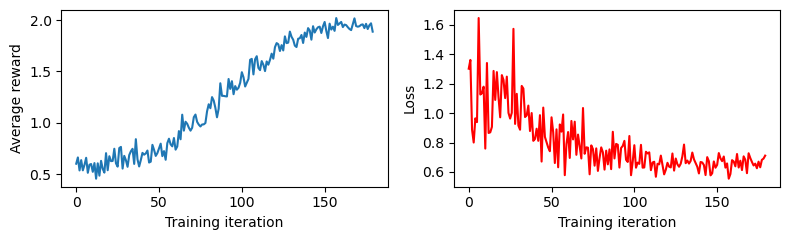

100%|██████████| 100/100 [00:02<00:00, 37.14it/s]


Sample trajectories: 100
[8.318, 8.603, 7.973, 1.813, 2.310, 2.080]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Cl)=C5Br
[8.534, 8.348, 7.837, 2.187, 1.864, 1.845]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5[N+1](=O)[O-1]
[8.736, 8.996, 7.603, 2.552, 3.042, 1.468]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C=C5F
[7.617, 7.804, 7.377, 0.817, 1.043, 1.139]    CNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[8.334, 8.240, 7.829, 1.840, 1.685, 1.832]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CN=CC(Br)=C5F
[8.500, 9.019, 7.856, 2.127, 3.085, 1.877]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Cl)=C5
[8.361, 8.832, 7.497, 1.886, 2.731, 1.308]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC=C(Cl)C5F
[8.253, 8.586, 7.676, 1.706, 2.279, 1.581]    

[6.215, 6.266, 7.063, 0.074, 0.081, 0.758]    COC(=O)C1=CC=CC(=C1)C2=CC=C(O2)C3C(C4=CC=CC=N4)NC(=S)N3C5=CC=C(C(C)=C5)NC(=O)C(C)C(CC6=CC=CC=C6)C(=O)NCC(C)C
[8.216, 8.793, 7.737, 1.646, 2.659, 1.680]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Cl)=C5Cl
[8.500, 8.641, 7.546, 2.127, 2.378, 1.381]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Cl)=C5[N+1](=O)[O-1]
[8.395, 8.395, 7.441, 1.945, 1.945, 1.228]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CN=CC(Cl)=C5F
[8.350, 8.829, 7.637, 1.867, 2.725, 1.521]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Cl)=C5F
[6.444, 5.932, 5.325, 0.114, 0.043, 0.035]    C123C=C1S24(N3)CC(C(OC)=C4OC)CN(CC)C(=O)CCCCCNCC5=NC(C)C=C5NC6CCCCC6
[8.099, 8.094, 7.481, 1.462, 1.454, 1.285]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=C(Br)C=C5Cl
[8.736, 8.996, 7.603, 2.552, 3.042, 1.468]    

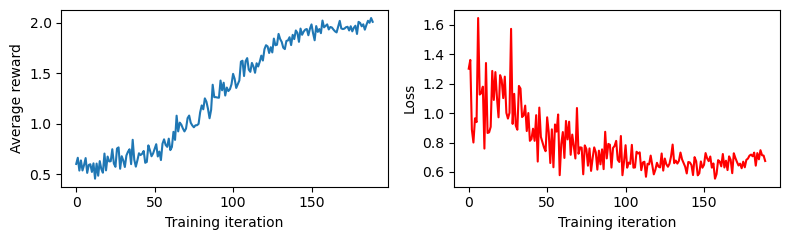

100%|██████████| 100/100 [00:02<00:00, 37.75it/s]


Sample trajectories: 100
[8.350, 8.829, 7.637, 1.867, 2.725, 1.521]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Cl)=C5F
[8.209, 8.019, 6.828, 1.635, 1.342, 0.536]    CCC(C(=O)NC1CCCC1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(S(C)(=O)=O)C3=CC(=CC=C3Cl)C(F)(F)F
[5.594, 6.452, 5.398, 0.022, 0.116, 0.040]    O=C(NC1=CC=C(OC)C=C1)N2CCN(CC2)C=NC(C3=CC=C4S35)(OC(=O)C6=CC=CC=C65)C7=CC=C(Br)C=C47
[8.736, 8.996, 7.603, 2.552, 3.042, 1.468]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C=C5F
[7.563, 7.900, 7.251, 0.758, 1.172, 0.976]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[8.318, 8.603, 7.973, 1.813, 2.310, 2.080]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Cl)=C5Br
[7.415, 8.301, 7.176, 0.612, 1.786, 0.884]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C=C5
[6.324, 5.891, 5.730, 0.091, 0.039, 0.076]    COC1=CC=C(C=C1Cl

[7.329, 7.325, 6.573, 0.537, 0.533, 0.355]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=NC6=CC=CC=C65
[8.773, 8.262, 7.962, 2.621, 1.720, 2.060]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Cl)=C5[N+1](=O)[O-1]
[8.454, 9.027, 7.810, 2.047, 3.100, 1.801]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C=C5F
[8.546, 9.083, 7.686, 2.208, 3.207, 1.599]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5Cl
[6.385, 7.091, 7.204, 0.102, 0.366, 0.918]    COC1=C(C=C2C=CC=CC2=C1Br)C(=O)NC3=CC=C4OC(=NC4=C3)C=CC=C(Br)S5C=CC=C(Br)C=C5N=C
[7.486, 7.078, 5.902, 0.679, 0.358, 0.105]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=C6C=CC=C(N6)CC5(N)C(C)C
[8.546, 9.083, 7.686, 2.208, 3.207, 1.599]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5Cl
[8.071, 8.343, 7.896, 1.419, 1.857, 1.

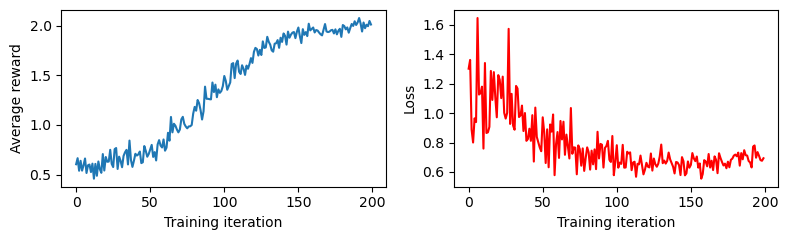

100%|██████████| 100/100 [00:02<00:00, 36.20it/s]


Sample trajectories: 100
[5.883, 6.103, 6.120, 0.039, 0.059, 0.159]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)N3C4=CC=C5OC(=NC5=C4)C3
[8.615, 9.111, 7.745, 2.331, 3.260, 1.692]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Cl)=C5F
[8.318, 8.603, 7.973, 1.813, 2.310, 2.080]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Cl)=C5Br
[7.789, 8.466, 7.315, 1.023, 2.067, 1.057]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC=CC=C3
[8.500, 9.019, 7.856, 2.127, 3.085, 1.877]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Cl)=C5
[6.643, 6.070, 5.155, 0.166, 0.056, 0.025]    O=C(C=CC(=O)N1CCCCCC1)CN(S(=O)(=O)C2=CC=CC=C2)C3=CC(=CC=C3Cl)C(F)(F)F
[8.775, 8.652, 7.822, 2.625, 2.398, 1.821]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5Br
[8.224, 8.840, 7.757, 1.658, 2.746, 1.712]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N

[8.164, 8.432, 7.608, 1.563, 2.009, 1.476]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Cl)=C5Cl
[6.720, 6.043, 5.131, 0.191, 0.053, 0.024]    CC=C1C=CC(C(C)=C1)N(S(C)(=O)=O)CCCC(=O)N(CC2=CC=C(Cl)C=C2Cl)C(C)C(=O)NC3CCCCC3
[8.425, 8.659, 7.593, 1.997, 2.413, 1.453]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC(Cl)=CC=C5[N+1](=O)[O-1]
[8.538, 8.960, 7.792, 2.194, 2.973, 1.770]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(F)=C5[N+1](=O)[O-1]
[8.454, 8.529, 7.444, 2.046, 2.178, 1.232]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC=C(Cl)C5Cl
[8.383, 8.770, 7.669, 1.924, 2.615, 1.570]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC=C(Br)C5
[7.647, 7.998, 7.321, 0.850, 1.311, 1.065]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(F)=C5
[8.347, 8.144, 7.745, 1.862, 1.532, 1.693]    O=C(C1

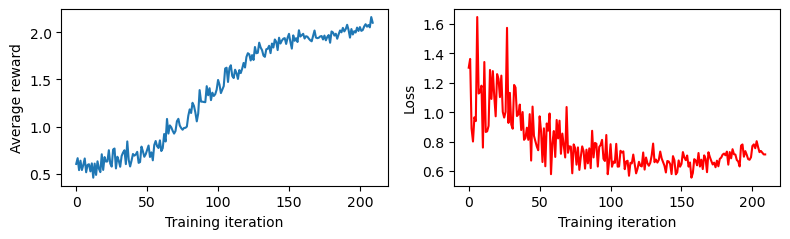

100%|██████████| 100/100 [00:02<00:00, 34.99it/s]


Sample trajectories: 100
[8.775, 8.908, 7.962, 2.626, 2.874, 2.061]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6F
[7.849, 8.332, 7.268, 1.102, 1.838, 0.997]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=C4C=C5OC(=NC5=C3)C6=CC=C(F)C(Br)=C64
[8.273, 8.731, 7.813, 1.739, 2.543, 1.806]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Br)=C5
[7.173, 8.138, 6.765, 0.418, 1.522, 0.486]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC=C5Br
[8.508, 8.444, 7.428, 2.141, 2.028, 1.210]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC=C(Br)C5F
[8.927, 8.534, 7.377, 2.910, 2.188, 1.140]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Cl)=C5C6C=CCC6Cl
[8.044, 6.178, 5.784, 1.379, 0.069, 0.084]    O=C(C1=CC=C(N2CCOCC2)C(=C13)[N+1](=O)[O-1])NC=C4CCN3NN4CC5=NC=CS5(C=O)C6=CC=CC7=CC=CC=C67
[8.871, 8.553, 7.979, 2.

[8.224, 8.840, 7.757, 1.658, 2.746, 1.712]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Cl)=C5Cl
[8.538, 8.960, 7.792, 2.194, 2.973, 1.770]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(F)=C5[N+1](=O)[O-1]
[8.874, 8.589, 7.760, 2.811, 2.285, 1.718]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Br)=C5C6C=CCC6
[8.775, 8.652, 7.822, 2.625, 2.398, 1.821]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5Br
[8.167, 8.670, 7.763, 1.568, 2.433, 1.723]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[8.098, 8.151, 7.722, 1.460, 1.542, 1.656]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5F
[8.461, 8.489, 7.709, 2.058, 2.108, 1.635]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=C(F)C(F)=C(F)C(F)=C5F
[8.385, 8.887, 7.694, 1.928, 2.835, 1.611]  

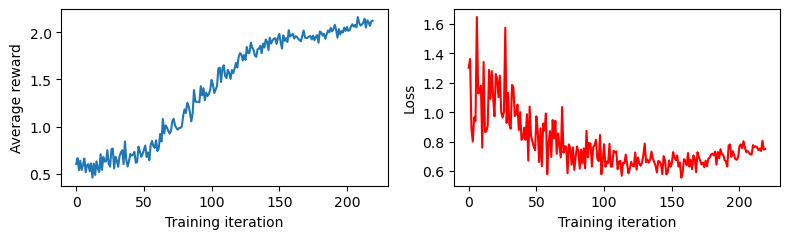

100%|██████████| 100/100 [00:02<00:00, 35.26it/s]


Sample trajectories: 100
[8.500, 9.019, 7.856, 2.127, 3.085, 1.877]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Cl)=C5
[7.687, 6.892, 7.197, 0.897, 0.259, 0.909]    [NH1]1NC1=COCCC(O)(C)CNC(C2CCCCC234)=NC=C(C5=CC6=CC=C53)C64
[8.823, 8.557, 7.689, 2.715, 2.228, 1.602]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Cl)=C5C[N+1](=O)[O-1]
[8.108, 7.963, 7.541, 1.476, 1.260, 1.374]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(F)C(F)=C(F)C(F)=C5F
[8.694, 9.009, 7.844, 2.475, 3.066, 1.858]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5F
[8.641, 7.991, 7.018, 2.379, 1.300, 0.711]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6N(C=O)CC7=CC=C(Cl)C=C7F
[7.795, 8.381, 7.146, 1.031, 1.921, 0.849]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Cl)=C5OC6=CC=CC(Cl)=C6F
[5

[8.838, 8.780, 8.143, 2.742, 2.635, 2.384]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6
[8.473, 8.912, 7.833, 2.079, 2.882, 1.840]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5Br
[6.650, 6.298, 6.218, 0.168, 0.087, 0.190]    O=C(NC1=CC(Cl)=CC=C1OC2=CC=CC=C2)CN(S(=O)(=O)C3=CC=CC=C3)C4=CC=C(Cl)C(=C4)C(F)(F)F
[8.374, 8.839, 7.849, 1.909, 2.745, 1.867]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Cl)=C5[N+1](=O)[O-1]
[7.263, 7.406, 7.166, 0.484, 0.604, 0.873]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C6=C(Br)C=CC(Br)=C6N5C
[8.838, 8.780, 8.143, 2.742, 2.635, 2.384]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6
[7.165, 7.367, 6.909, 0.413, 0.569, 0.606]    O=C(C1=CC=CC(=C1)[N+1](=O)[O-1])NC(=S)NC2=CC=C3OC(=NC3=C2)C=C4C=CC=C(C4)C(F)(F)F
[8.694, 9.009, 7.844, 2.475, 3.066,

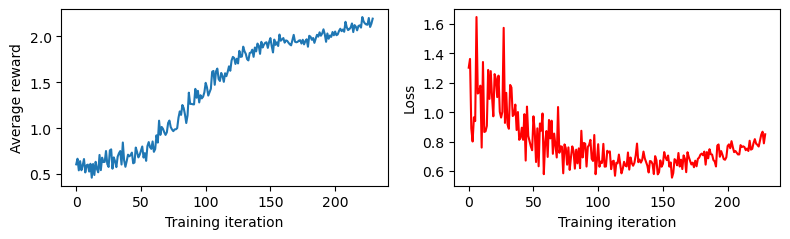

100%|██████████| 100/100 [00:02<00:00, 34.22it/s]


Sample trajectories: 100
[6.644, 6.311, 6.344, 0.166, 0.089, 0.238]    O=COCC=CC=C1C=CC=CC1SC2COC=CC=C(Cl)C(Br)=C2C3=NC4=CC=CC=C4S3
[5.544, 4.884, 5.332, 0.020, 0.005, 0.035]    O=C(S(=O)(=O)N1CCC2=CC=CC=C21)N3CCCCC4(CCN(CC4)CC5=CC=CC=N5)C(=O)OCC(O)C(O)CC3
[5.820, 6.390, 5.407, 0.034, 0.103, 0.040]    CCOC(=O)C1=C(C)N(C2=CC=CC(C)=C2)C(=O)C1=CC3=CC=C(O3)SC4=NC5=CC=C(C=C5S4)NC(=O)C6=CC=CC=C6C(O)=O
[8.446, 8.941, 7.607, 2.033, 2.937, 1.474]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Br)=C5
[8.433, 8.667, 7.583, 2.011, 2.427, 1.437]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C=C5F
[8.694, 9.009, 7.844, 2.475, 3.066, 1.858]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5F
[8.432, 8.569, 8.014, 2.008, 2.249, 2.151]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(F)=C5F
[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)

[8.500, 8.641, 7.546, 2.127, 2.378, 1.381]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Cl)=C5[N+1](=O)[O-1]
[8.775, 8.908, 7.962, 2.626, 2.874, 2.061]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6F
[8.452, 8.128, 7.768, 2.043, 1.506, 1.731]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C7=CCC6(O7)C8=CC=CC(Br)=C8
[8.273, 8.731, 7.813, 1.739, 2.543, 1.806]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(Br)=C5
[8.838, 8.780, 8.143, 2.742, 2.635, 2.384]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6
[8.781, 9.040, 7.654, 2.636, 3.126, 1.547]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5F
[8.656, 8.614, 8.038, 2.406, 2.331, 2.194]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Cl)=C5F


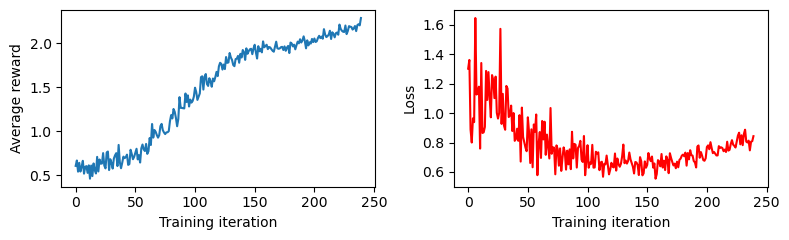

100%|██████████| 100/100 [00:02<00:00, 35.08it/s]


Sample trajectories: 100
[8.432, 8.569, 8.014, 2.008, 2.249, 2.151]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(F)=C5F
[8.919, 8.551, 7.945, 2.894, 2.217, 2.030]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Br
[8.517, 9.151, 7.647, 2.158, 3.339, 1.536]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Br)=C5F
[7.143, 7.021, 6.770, 0.398, 0.325, 0.489]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5SC=SOC
[8.775, 8.908, 7.962, 2.626, 2.874, 2.061]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6F
[4.786, 4.369, 4.704, 0.004, 0.002, 0.010]    O=C(C(=O)C1=CC=C(Cl)C=C1Cl)NCC(N2CCOCC2)C3=CC=C(C=C3)[N+1](=O)[O-1]
[7.341, 7.925, 7.194, 0.546, 1.206, 0.905]    CCC(C(=O)NC(C)(C)C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[8.224, 8.840, 7.757, 1.658, 2.746, 1

[6.876, 5.902, 6.104, 0.252, 0.040, 0.154]    O=C(NCC1=CC=C(C=C1)CN2CCOCC2)CN(C3=CC=C(Cl)C(Cl)=C3)S(=O)(=O)C4=CC=CC=C4
[8.612, 9.230, 7.664, 2.327, 3.490, 1.563]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Br)=C5O
[8.694, 9.009, 7.844, 2.475, 3.066, 1.858]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5F
[8.694, 9.009, 7.844, 2.475, 3.066, 1.858]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5F
[5.948, 5.379, 5.671, 0.044, 0.014, 0.068]    O=CC=CCOC(=O)C1=CC=C(C=C1Cl)NS(=O)(=O)C2=CC=CC=C2
[5.825, 5.961, 5.713, 0.034, 0.045, 0.073]    O=C(C1=CC(Br)=CC=C1OC)NC2=NC(C3=CC=CC=C3)=C(S2)C4=CC=CC=C4
[9.369, 8.969, 7.711, 3.761, 2.990, 1.638]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Br)=C5C6C=CCC6[N+1](=O)[O-1]
[7.324, 7.668, 6.586, 0.533, 0.875, 0.362]    CC1(C)CC=NCSC=CC=C2CCCC=C2NC3=C1C(=CC(Cl)=C3OCC4=CC=C(Cl)C(Cl)=C4)C5=CC=C(F)C=C5F

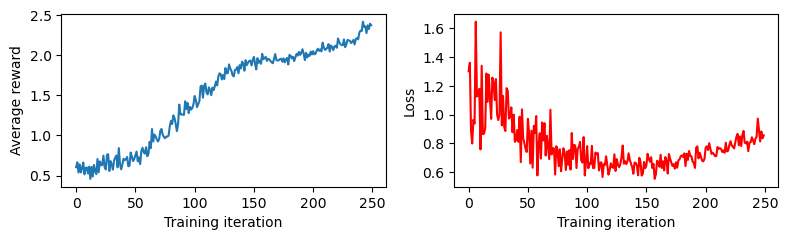

100%|██████████| 100/100 [00:03<00:00, 32.28it/s]


Sample trajectories: 100
[5.707, 5.071, 4.922, 0.027, 0.008, 0.016]    O=CNCCCOC1=CC=CC=C1NC(=S)NC2=CC=C3OC(=NC3=C2)C=CC4=C(Br)C=CC(Br)=C4CCC
[8.517, 9.151, 7.647, 2.158, 3.339, 1.536]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Br)=C5F
[8.694, 9.009, 7.844, 2.475, 3.066, 1.858]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5F
[8.781, 9.040, 7.654, 2.636, 3.126, 1.547]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5F
[8.789, 8.853, 7.491, 2.650, 2.771, 1.300]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C=C5Cl
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[9.017, 8.759, 8.307, 3.081, 2.595, 2.685]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5F
[9.017, 8.759, 8.307, 3.081, 2.595, 2.685] 

[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[6.700, 7.428, 6.639, 0.184, 0.624, 0.396]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5CC6=CC(C)=CC(C)=C6Cl
[8.775, 8.908, 7.962, 2.626, 2.874, 2.061]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6F
[8.964, 8.672, 8.096, 2.981, 2.436, 2.298]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Cl)=C5[N+1](=O)[O-1]
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[7.711, 7.669, 7.177, 0.926, 0.876, 0.886]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(C(Cl)=C5)[N+1](=O)[O-1]
[7.748, 7.517, 7.332, 0.972, 0.710, 1.080]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC=CC=COCC=CC3=C(Br)C=CC

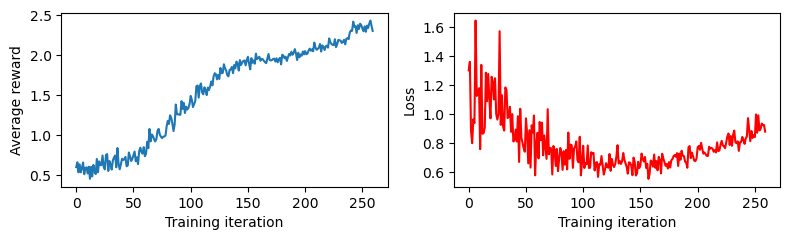

100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


Sample trajectories: 100
[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[6.533, 6.687, 6.372, 0.135, 0.180, 0.251]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC=CC=COCC3=CC=CC(=C3)C(=O)C4=CC=CO4
[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[5.513, 4.974, 5.768, 0.019, 0.006, 0.082]    O=C(CC=COCC(N)=O)CCC(=O)OC=C1C=CC(Br)=C(Br)C1=O
[7.781, 7.696, 7.308, 1.013, 0.908, 1.048]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5NC=CC=CC=CS
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[8.446, 8.941, 7.607, 2.033, 2.937, 1.474]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Br)=C5
[7.992, 8.173, 7.540, 1.301, 1

[9.483, 8.690, 8.142, 3.984, 2.469, 2.381]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6
[8.615, 9.111, 7.745, 2.331, 3.260, 1.692]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Cl)=C5F
[7.685, 7.614, 6.784, 0.896, 0.814, 0.501]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(C=C5)S(=O)(=O)NC6=CC=C(F)C=C6F
[8.781, 9.040, 7.654, 2.636, 3.126, 1.547]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5F
[5.510, 5.379, 5.145, 0.019, 0.014, 0.024]    O=C(O)CCCNC=CSCC(=O)NC1=CC=C(C=C1)S(=O)(=O)NC(C)C
[6.777, 6.359, 5.602, 0.212, 0.097, 0.059]    COC=CC=CC1C=C(CC=C1OCC(=O)NC2=CC=C(C)C(C)=C2)NNCCCCCCCCNC(=O)C3=CC=C(C=C3)OCC4=CC=CC=C4Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[5.376, 4.961, 4.960, 0.014, 0.006, 0.017]    O=C(CC(

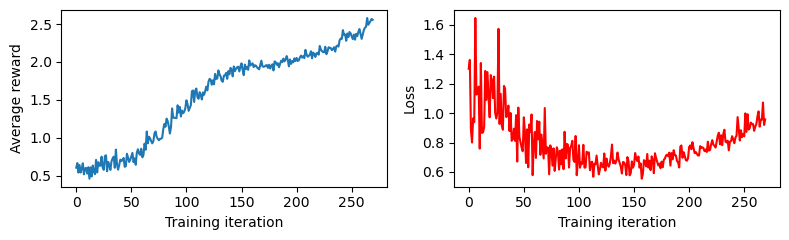

100%|██████████| 100/100 [00:03<00:00, 32.08it/s]


Sample trajectories: 100
[9.482, 8.876, 7.888, 3.984, 2.813, 1.932]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Cl)=C5C6C=CCC6Cl
[9.487, 8.819, 7.959, 3.992, 2.706, 2.055]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6NCC7=CC=CC=C7F
[5.799, 5.568, 5.497, 0.033, 0.021, 0.048]    CCC(C(=O)NC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC=CC(Cl)=C2Cl
[9.133, 8.911, 7.607, 3.304, 2.880, 1.473]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5C6C=CCC6Cl
[9.096, 8.965, 8.218, 3.233, 2.982, 2.520]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6C7C=CCC7F
[9.017, 8.759, 8.307, 3.081, 2.595, 2.685]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5F
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C

[8.461, 8.489, 7.709, 2.058, 2.108, 1.635]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=C(F)C(F)=C(F)C(F)=C5F
[8.781, 9.040, 7.654, 2.636, 3.126, 1.547]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Cl)=C5F
[7.395, 7.677, 6.360, 0.594, 0.886, 0.245]    O=C(C=1SC2=CC=CC=C2C=1Cl)NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Br)=C5C6C=CC7C6(NC8=CC(=CC=C87)S(=O)(=O)N(C)C)Cl
[9.456, 9.193, 7.894, 3.931, 3.420, 1.942]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6[N+1](=O)[O-1]
[8.347, 8.144, 7.745, 1.862, 1.532, 1.693]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C(Br)=C5[N+1](=O)[O-1]
[8.779, 7.753, 7.333, 2.632, 0.978, 1.081]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=C(Br)C5=CC(Br)=CC=C5C6C=CCC6Br
[9.118, 8.927, 8.138, 3.274, 2.910, 2.373]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3

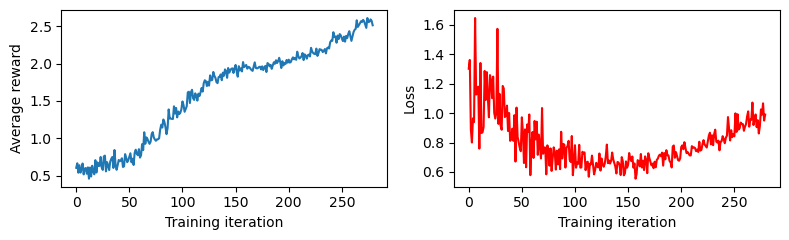

100%|██████████| 100/100 [00:03<00:00, 31.63it/s]


Sample trajectories: 100
[9.017, 8.759, 8.307, 3.081, 2.595, 2.685]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5F
[8.694, 9.009, 7.844, 2.475, 3.066, 1.858]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5F
[9.220, 7.801, 7.401, 3.471, 1.039, 1.173]    O=C(C1=CC(Br)=CC=C1Cl)NC(=S)NC2=CC=C3OC(=NC3=C2)C=CC4=C(Br)C=CC(Br)=C4C5C=CCC5Cl
[8.098, 8.151, 7.722, 1.460, 1.542, 1.656]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5F
[6.714, 7.299, 5.864, 0.188, 0.512, 0.098]    COC(=O)C(SC=S)=CC1=CC(Br)=CC=C1OCC2=CC=C(Br)C=C2F
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.051, 6.480, 6.510, 0.342, 0.122, 0.319]    CCNC(=O)

[7.887, 8.096, 7.571, 1.153, 1.458, 1.419]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(C=C5Br)[N+1](=O)[O-1]
[5.268, 5.082, 5.104, 0.011, 0.008, 0.022]    O=CCCC(C(=O)OCC1=CC=CC=C1)NC(=O)C2=CC=CC=C2[N+1](=O)[O-1]
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.101, 6.243, 6.756, 0.371, 0.078, 0.479]    O=C(N1CCN(CC1)CC2=CC=C3C(=C2)OCO3)CN(C4=CC=C(Cl)C=C4Cl)S(=O)(=O)C5=CC=CC=C5
[6.721, 6.784, 7.049, 0.191, 0.214, 0.743]    CCCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(S(=O)(=O)C3=CC=CC=C3)C4=CC(=CC=C4Cl)C(F)(F)F
[9.017, 8.759, 8.307, 3.081, 2.595, 2.685]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5F
[8.964, 8.672, 8.096, 2.981, 2.436, 2.298]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Cl)=C5[N+1](=O)[O-1]
[9.017, 8.759, 8.307, 3.081, 2.595, 2.685]    O=C(

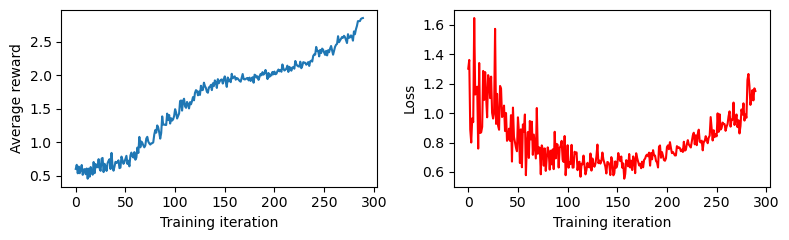

100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Sample trajectories: 100
[8.866, 8.369, 7.838, 2.796, 1.900, 1.847]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C7=CCC6C8C=CCC87
[7.443, 7.286, 6.977, 0.638, 0.502, 0.671]    CC=NN(C1=CC=CC=C1)C=CC=CCC(C2=CC=CC=C2)(O)CNCCCCCOC3=C4C=CC=C3C=CC=CCC4C5=CC=C(C=C5)OC6OC(CO)C(O)C(O)C6OCOC(C)C(=CC7=C8C=CC=CC8=CC9=CC=CC=C79)OC(=O)[NH1]C(=O)NC%10=CC=C(Br)S%10
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[5.889, 6.121, 6.644, 0.039, 0.062, 0.399]    CC1=NC2=NC=NN2C(C)=C1CCC(=O)N3CCN(CC3)S(=O)(=O)C4=CC=C(Cl)S4OCSCC5=CC=CC=C5F
[9.017, 8.759, 8.307, 3.081, 2.595, 2.685]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5F
[7.350, 8.265, 7.152, 0.554, 1.726, 0.857]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5OCCCCCCC6=CC=C(Br)C=C6F
[9.734, 8.974, 8.259, 4.479, 2.999, 

[7.535, 7.440, 6.645, 0.729, 0.635, 0.400]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=C(Br)C=CC(=N)[N+1](=O)[O-1]
[9.595, 8.934, 7.881, 4.205, 2.924, 1.921]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6C7C=CCC7Cl
[8.514, 8.973, 7.706, 2.152, 2.996, 1.630]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6N7CCOCC7F
[9.017, 8.759, 8.307, 3.081, 2.595, 2.685]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5F
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[6.741, 7.289, 7.311, 0.198, 0.504, 1.052]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C

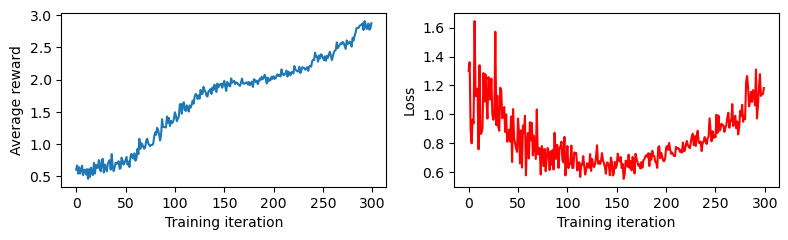

100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Sample trajectories: 100
[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[7.729, 8.377, 7.122, 0.948, 1.913, 0.823]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Cl)C=C5CC6CC6[N+1](=O)[O-1]
[7.709, 7.368, 6.712, 0.924, 0.570, 0.446]    C1N(C)CC12CCC(C)OCC=CC=C2C(C)CCCCNC=CC=COCOC(=O)C3=CC=CC=C3
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[8.919, 8.551, 7.945, 2.894, 2.217, 2.030]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Br
[7.680, 7.852, 6.644, 0.890, 1.106, 0.399]    C([O-1])C1=CN(N=N1)C2=CC(N3CCN(CC3)C4=CC=CC=C4)=NC(=N2)NC(=S)NCC5=CC=C(Cl)C=C5F
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.941, 7.2

[8.270, 7.910, 7.492, 1.734, 1.184, 1.302]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=C(Br)C5=CC=CC=C5C6=CC=C(Br)S6C=CF
[6.891, 7.037, 6.770, 0.259, 0.334, 0.489]    O=C(C1=CC=CC(=C1)C(F)(F)F)N2CCCC3=CC(=CC=C32)S(=O)(=O)NCC4=CC=CC=C4S(=O)(=O)N5CCCC5
[5.231, 4.639, 5.475, 0.011, 0.003, 0.046]    O=CNCCCCOC=CC=CCSC=NC=CCCC1=CC=CC=CC=CC=C1C2=CC=CC(Cl)=C2F
[8.384, 8.022, 7.722, 1.925, 1.346, 1.656]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5O[N+1](=O)[O-1]
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[6.355, 5.060, 5.510, 0.097, 0.008, 0.050]    O=CCNC1=NC(C2=CC=C(Cl)C=C2)=NC(=N1)NC3=C(Cl)C(C)=C(Cl)C(F)=C3C=CNC4CN(C=O)CC4=O
[8.257, 8.190, 7.683, 1.712, 1.604, 1.593]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6CC7=CC=CC=C7Cl
[9.409, 9.419, 7.951, 3.839, 3.

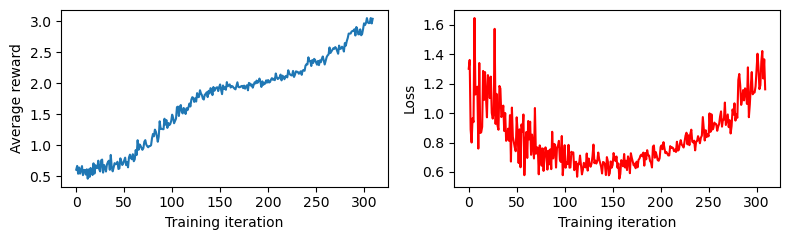

100%|██████████| 100/100 [00:03<00:00, 27.88it/s]


Sample trajectories: 100
[6.731, 5.812, 5.526, 0.194, 0.034, 0.051]    CCNC=C(NC1=CC=C(F)C=C1)CC2=CC=C(C=C2)NC(=S)NC(=O)C3=CC(Br)=NC(=N3)CC=C4CCC(C)=N4
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[9.017, 8.759, 8.307, 3.081, 2.595, 2.685]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5F
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[6.950, 7.091, 6.699, 0.287, 0.366, 0.437]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)CBr
[9.734,

[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.483, 8.690, 8.142, 3.984, 2.469, 2.381]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6
[8.918, 8.588, 7.919, 2.894, 2.284, 1.986]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Cl)=C5C6C=CCC6F
[9.482, 8.876, 7.888, 3.984, 2.813, 1.932]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Cl)=C5C6C=CCC6Cl
[9.554, 8.820, 8.160, 4.124, 2.709, 2.414]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6OOF
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=

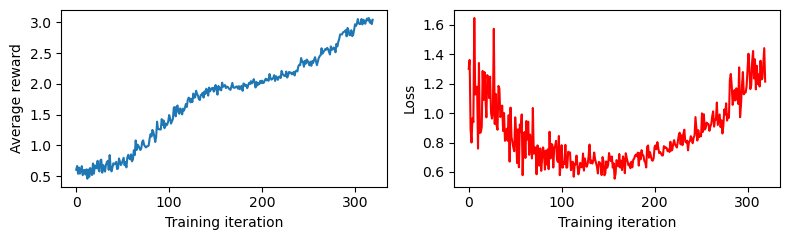

100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Sample trajectories: 100
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[5.941, 5.919, 6.566, 0.043, 0.041, 0.351]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(F)C=C2)C(=O)CN(S(C)(=O)=O)C3=CC=CC(Br)=C3F
[8.856, 8.815, 7.826, 2.777, 2.700, 1.827]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Cl)=C5C6C=CCC6C7C=CCC7[N+1](=O)[O-1]
[8.565, 8.181, 7.887, 2.243, 1.590, 1.930]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=C(Br)C=CC=C(Cl)CF
[8.555, 8.781, 7.807, 2.225, 2.637, 1.796]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(F)C(F)=C5Br
[6.013, 5.708, 5.097, 0.050, 0.027, 0.022]    O=C(NC1=CC=CC(Cl)=C1Cl)CN(CC2=CC=CC=C2F)S(=O)(=O)C3=CC=C(Br)C=C3
[6.761, 7.307, 6.446, 0.206, 0.518, 0.285]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(C=C5)OCC6=CC=CC=C6Br
[6.667, 7.024

[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[6.274, 5.400, 5.797, 0.083, 0.015, 0.086]    COC1=CC=2C=C(C(=O)[NH1]C=2C=C1OC)CNONCCN3CCN(CC3)C4=CC=C(Cl)C=C4[N+1](=O)[O-1]
[3.104, 2.757, 3.383, 0.000, 0.000, 0.001]    NC1=NC=NC2=C1N=CN2
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.326, 6.900, 6.368, 0.534, 0.263, 0.249]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6C=CN=C=CC7=CC(=CC=C7Cl)N
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[9.259, 8.891, 8.261, 3.547, 2.842, 2.600]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6
[9.097, 8.754, 8.069, 3.235, 2.586, 2.249]    O=C(C1=CC=C(

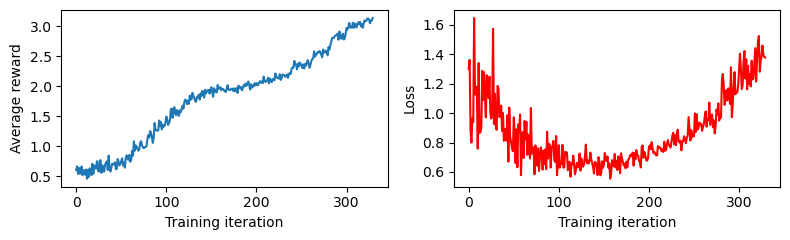

100%|██████████| 100/100 [00:03<00:00, 25.46it/s]


Sample trajectories: 100
[9.482, 8.876, 7.888, 3.984, 2.813, 1.932]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Cl)=C5C6C=CCC6Cl
[6.009, 5.136, 5.151, 0.049, 0.009, 0.024]    O=CCOC=CCC=CC1CC(=O)OC=CC=C(Br)C=C1C2=CC(Br)=CC(Br)=C2OCC3=CC=C(Cl)C(Cl)=C3Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC

[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.162, 7.964, 6.413, 1.560, 1.261, 0.269]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6OC=CC=C(Cl)C(C7=NN=NN7C89CCC%10C8)NC(C)(C%10C9=O)C%11CC%11
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[8.694, 9.009, 7.844, 2.475, 3.066, 1.858]    O=C(C1=CC=C(N2CCOCC2)C(=C

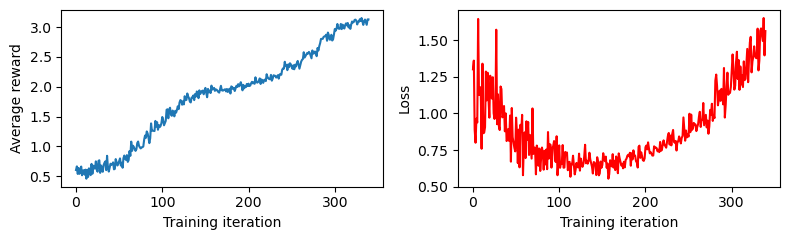

100%|██████████| 100/100 [00:04<00:00, 24.06it/s]


Sample trajectories: 100
[9.017, 8.759, 8.307, 3.081, 2.595, 2.685]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5F
[5.596, 5.039, 5.675, 0.022, 0.007, 0.068]    COC=CC=CCOSSCC(=O)N(CC1=CC=C(Cl)C=C1Cl)C(C)C(=O)NC2CCCCC2
[3.011, 2.947, 3.375, 0.000, 0.000, 0.001]    N1OC2=CC=CC=C21
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[

[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.223, 8.846, 7.780, 3.477, 2.758, 1.751]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC67C=NC8=CC=CC=C8OC9=NC=CC=C97
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.915, 8.036, 7.122, 1.192, 1.366, 0.822]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=C7CC6(C(=O)N7CC8=CC=C(C=C8)N(C)C)C=CC=CNNC9=CC=CC=C9C(=O)NC=O
[9.734, 8.974, 8.259, 4.479, 2.999, 2.59

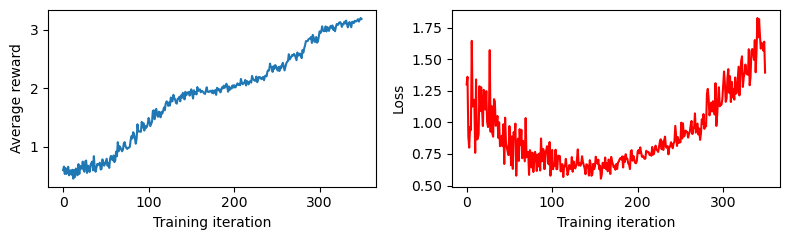

100%|██████████| 100/100 [00:04<00:00, 23.57it/s]


Sample trajectories: 100
[6.857, 7.279, 5.863, 0.244, 0.496, 0.098]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5OC(OC)=COCCCCCCOC6=CC=C(Br)C=C6
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.913, 7.985, 6.761, 1.188, 1.292, 0.482]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6C=O
[5.563, 5.526, 5.339, 0.021, 0.019, 0.035]    C1C=C1OCC2=CC=C3C=CC=CC3=C2C=O
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[

[4.840, 4.407, 4.792, 0.005, 0.002, 0.012]    O=C(NN)COC(=O)CNCCSC1=NN=C(N1C)C(F)(F)F
[7.152, 7.053, 6.035, 0.404, 0.343, 0.136]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5CCCC
[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.808, 8.733, 7.478, 2.687, 2.547, 1.281]    O=C(CC1=CC=C(Cl)C=C1Cl)NC(=S)NC2=CC=C3OC(=NC3=C2)C=CC4=C(Br)C=CC(Br)=C4C5C=CCC5Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC

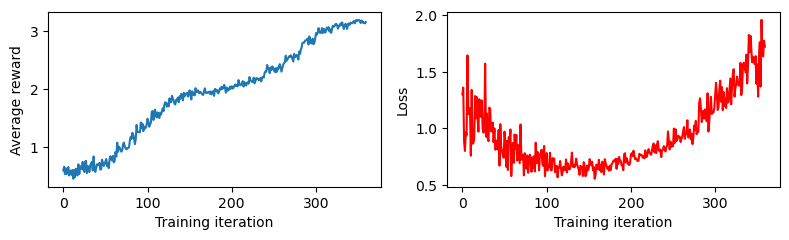

100%|██████████| 100/100 [00:04<00:00, 23.61it/s]


Sample trajectories: 100
[8.712, 8.608, 6.922, 2.509, 2.319, 0.618]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6NCCCC7NCCCNN7C(O)=NC(=O)C=C(COCC8=CC=CC=C89)C=CC(F)=CC(F)=C9F
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[5.935, 6.387, 4.986, 0.043, 0.102, 0.018]    O=C(N(C)C=S)C1=CC=C(N2CCCCC2)C(=C1)[N+1](=O)[O-1]
[5.909, 5.312, 5.876, 0.041, 0.013, 0.100]    O=C(C(=C)[N+1](=O)[O-1])NCC(C)(C)OC(CCC)CCCC1CC2=CC=CC=C21
[6.076, 6.060, 6.056, 0.056, 0.055, 0.141]    O=C(C1=CC=C(C)C=C1)CNN=C(C2=CC=C(C=C2)S(C)(=O)=O)NC(=S)NC(C3=CC=CC=C3)=CC4=CC=CC=C4OCC5=CC=CC=C5Cl
[9.097, 8.754, 8.069, 3.235, 2.586, 2.249]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6F
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(

[6.354, 6.888, 6.431, 0.096, 0.258, 0.278]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)S5F
[9.017, 8.759, 8.307, 3.081, 2.595, 2.685]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5F
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.555, 8.490, 7.749, 2.224, 2.109, 1.700]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6S
[7.323, 7.355, 6.988, 0.532, 0.559, 0.681]    O=C(NCCCNC1=CC=NC2=CC(Cl)=CC=C12)CN(CC3=CC=C(Cl)C(Cl)=C3)S(=O)(=O)C4=CC=C(Cl)C=C4F
[9.734, 8.974, 8.259

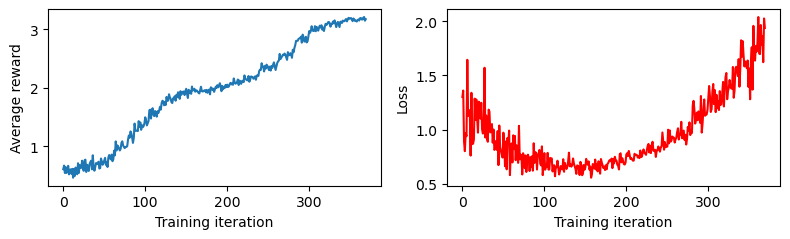

100%|██████████| 100/100 [00:04<00:00, 21.35it/s]


Sample trajectories: 100
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[9.876, 8.966, 8.293, 4.761, 2.984, 2.659]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6NC=CC(Br)=C7C=CC=CC7NBr
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[5.055, 4.789, 5.213, 0.007, 0.004, 0.028]    O=C(C1=CC=C(Br)C=C1)NC(CC2=C[NH1

[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[7.522, 7.068, 6.355, 0.716, 0.352, 0.243]    O=C(NCC1=CC=C(C=C1)S(=O)(=O)N2CCCC2)CN(S(=O)(=O)C3=CC=CC=C3)C4=CC(=CC=C4Cl)C(F)(F)F
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.441, 6.847, 6.464, 0.636, 0.240, 0.295]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)S5C6=CC=C(Br)C(Br)=C6C7C=C8C=9C7(C(C)N8C%10=CC=C(Br)C=C%10)[N+1]=9
[9.483, 8.690, 8.142, 3.984, 2.469, 2.381]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[7.440, 7.226, 6.588, 0.635, 0.456, 0.364]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)N

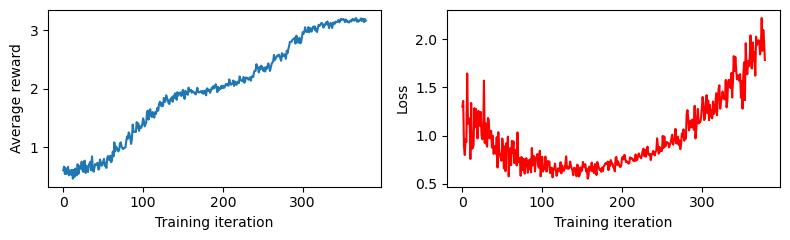

100%|██████████| 100/100 [00:04<00:00, 21.88it/s]


Sample trajectories: 100
[8.653, 8.449, 7.785, 2.401, 2.038, 1.759]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CC=C6
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.656, 8.614, 8.038, 2.406, 2.331, 2.194]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Cl)=C5F
[8.161, 8.122, 7.504, 1.558, 1.498, 1.319]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6OCC7=CC=CC8=C7CCC=CC8
[5.993, 5.605, 5.995, 0.048, 0.022, 0.126]    O=COC=CC=C1C=CC=CC1COC2=CC=C(Cl)C=C2C=C3C(=O)N(C4=CC=C(Cl)C=C4)C(=S)N(C3=O)C5=CC=CC(Cl)=C5F
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S

[6.535, 5.613, 5.843, 0.136, 0.023, 0.094]    O=C(N1CCN(CC1)CC2=CC=C3C(=C2)OCO3)C4CCN(CC4)S(=O)(=O)CC5=CC=C(Br)C=C5[N+1](=O)[O-1]
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.282, 9.092, 8.244, 3.592, 3.225, 2.568]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6C7C=CCC7F
[8.866, 8.709, 7.869, 2.794, 2.503, 1.900]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=C(Br)C5=CC(Br)=C(C(Br)=C5)OCC6=CC=C(Cl)C(Cl)=C6Cl
[7.425, 7.614, 7.111, 0.621, 0.813, 0.810]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6C=CN7CCCOCN(C)C7=O
[9.482, 8.876, 7.888, 3.984, 2.813, 1.932]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC

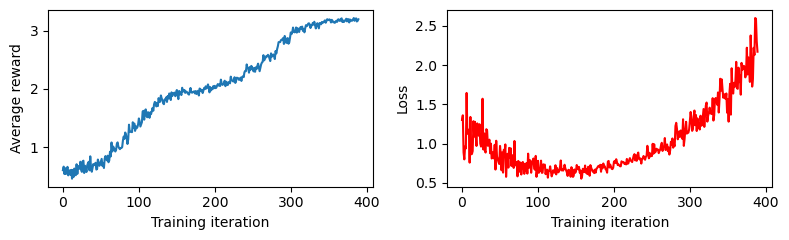

100%|██████████| 100/100 [00:05<00:00, 18.99it/s]


Sample trajectories: 100
[7.565, 8.044, 6.968, 0.760, 1.378, 0.662]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)COC(=O)C5=CC=C(C=C5Cl)[N+1](=O)[O-1]
[8.893, 8.734, 7.820, 2.846, 2.550, 1.817]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC6=C(Br)C=CC(Br)=C6S5OCCN7CCCCC78N=NC=CC(S(O)(=O)=O)(C9=CC=CC=C98)C[N+1](=O)[O-1]
[7.132, 7.830, 6.582, 0.391, 1.076, 0.360]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(C(=C5)OCC)OCC6=CC=CC=C6Cl
[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.837, 9.364, 8.327, 4.684, 3.751, 2.

[9.017, 8.759, 8.307, 3.081, 2.595, 2.685]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5F
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.716, 7.819, 7.499, 0.933, 1.062, 1.312]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=C6C(Br)=C5N=C6
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.482, 8.876, 7.888, 3.984, 2.813, 1.932]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Cl)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C

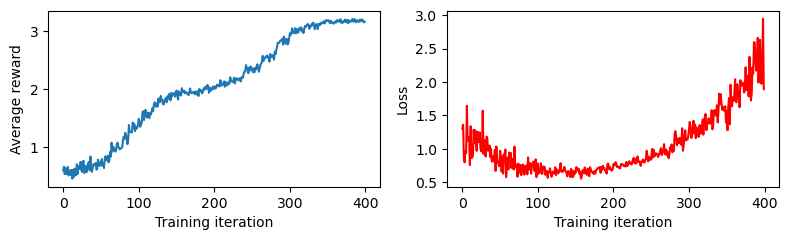

100%|██████████| 100/100 [00:05<00:00, 17.94it/s]


Sample trajectories: 100
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.839, 9.070, 8.266, 4.687, 3.183, 2.609]    O=C(C1=CC=C(N2CCCCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[5.685, 5.224, 5.357, 0.026, 0.010, 0.037]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])N3C(=S)NCC4=CC=C(Br)C=C4C3=NC=CC#CCl
[9.212, 9.191, 8.058, 3.456, 3.415, 2.230]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CC7C6C=CCS7(O8)=CC(=O)C8Cl
[8.616, 8.047, 7.327, 2.333, 1.382, 1.073]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C=CC(Br)C=N5
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=

[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.443, 7.021, 6.240, 0.638, 0.325, 0.198]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5CC(COC6=CC=C(Cl)C=C6Cl)OCCCCNNC=CC(C7CCOCC7)=NC(C(O)=CC=O)SC8=N[NH1]C(=N8)C9=CC=CC(Cl)=C9
[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.984, 8.649, 8.184, 3.019, 2.393, 2.458]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6NC7=CC=COC(Br)C=CC=C7
[9.566, 8.908, 8.201

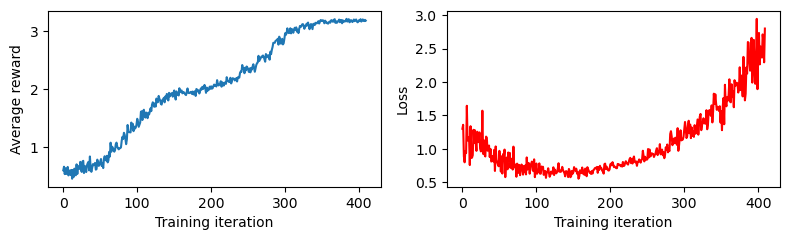

100%|██████████| 100/100 [00:05<00:00, 18.93it/s]


Sample trajectories: 100
[6.134, 5.234, 5.432, 0.063, 0.011, 0.043]    CC1=CC=C(C=C1)CN(C(C)C(=O)NC(C)(C)C)C(=O)CN(S(=O)(=O)C2=CC=CC=C2)C3=CC(=CC=C3Cl)C(F)(F)F
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[5.891, 5.855, 5.759, 0.039, 0.037, 0.080]    CCC(C1=CC=C(C)C=C1)NC(=O)CN(S(=O)(=O)C2=CC=CC=C2)C3=CC(=CC=C3Cl)C(F)(F)F
[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[7.563, 7.900, 7.251, 0.758, 1.172, 0.976]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2Cl)C(F)(F)F
[4.907, 4.108, 5.149, 0.006, 0.001, 0.024]    O=C=NNNC1=CC=C(C=C1)S(=O)(=O)NCCC2=CC=CC=C2
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCO

[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.378, 8.126, 7.808, 1.915, 1.503, 1.797]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C6=CC(Br)=C56
[5.697, 6.200, 5.463, 0.027, 0.072, 0.045]    CCCC1=C(C(=O)OCC)C(C2=CC=C(C=C2)C(C)C)N3C(=N1)SC(C3=O)=CC4=CC=C(C(=C4)OCC)OCC5=CC=C(Br)C=C5Br
[7.687, 7.504, 6.671, 0.897, 0.697, 0.418]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=C6C=C(Br)CC(Br)=C6C7C=C8CC75C=N8
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.258, 8.987, 7.918, 3.546, 3.025, 1.984]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6[N+1]C7C=CCC7Br
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C

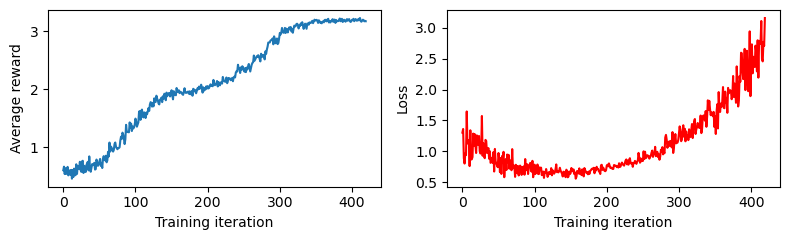

100%|██████████| 100/100 [00:05<00:00, 19.59it/s]


Sample trajectories: 100
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.067, 7.505, 7.633, 0.351, 0.698, 1.515]    CCCCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=CC=C3
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[5.305, 5.196, 5.331, 0.012, 0.010, 0.035]    O=C(N1CCN(CC1)C2=CC=CC=C2)COC3=CC=C(C=C3Cl)S(=O)(=O)N4CCCC5=CC=CC=C54
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC

[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.100, 8.615, 8.073, 3.240, 2.332, 2.256]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C6=C(Br)C=CC(Br)=C6C5(Cl)F
[8.162, 8.717, 7.748, 1.560, 2.517, 1.698]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5N=NC6=CC(SC6=C)C=7N=NNC=7
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=N

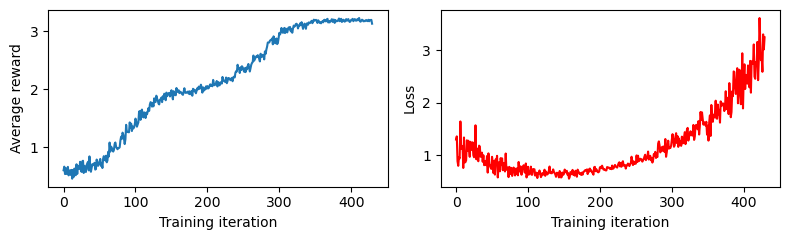

100%|██████████| 100/100 [00:04<00:00, 20.30it/s]


Sample trajectories: 100
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.750, 7.255, 6.445, 0.974, 0.478, 0.285]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC6=C(Br)C=CC(Br)=C6C7C=CCC75CC=CCC=CCCNCCC=O
[8.910, 8.267, 8.008, 2.878, 1.729, 2.141]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6NCCCCNC7=NC8=CC=CC=C8N7
[9.097, 8.754, 8.069, 3.235, 2.586, 2.249]    O=C(C1=CC=

[7.998, 8.098, 7.429, 1.310, 1.460, 1.212]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C6=CC(Br)=C5C7C8=CCC76C=C8S
[6.658, 7.064, 6.366, 0.170, 0.349, 0.248]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(C3=CC=C(N4CCOCC4)C(=C3)[N+1](=O)[O-1])CCCSC=NC=NCSC=CC(=O)OC5=CC=CC=C5S(=O)(=O)O
[9.045, 8.048, 7.396, 3.134, 1.384, 1.166]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=C(Br)SC=CC=C(Br)SNC5=C6C=C(Cl)C(Cl)=C56
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N

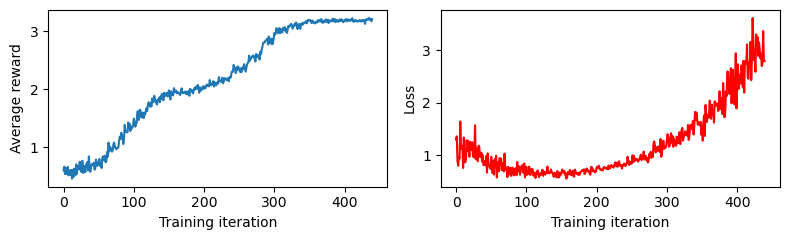

100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


Sample trajectories: 100
[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[8.017, 5.943, 6.092, 1.339, 0.043, 0.151]    O=C(CC1=CC=C(Cl)C=C1Cl)NCSC=CCC2=NC=C(C=C2)S(=O)(=O)NC3=CC4=CC=C3N4C5CC5
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.035, 8.314, 7.720, 3.115, 1.807, 1.652]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=C6C(Br)=C5C7C=CCC76
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.458, 7.514, 6.117, 0.652, 0.708, 0.158]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=C(

[7.822, 8.199, 6.518, 1.067, 1.619, 0.323]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5COC=NC=NC=C6C=C(CC=C6OCCOC7=CC=C(C)C(C)=C7)N8CCC(N=C8C9=CC=CC%10=C9)C%11C%12=CC%13=CC=C%12N=C%13CCCCS(O%14)(=O)CCCN%14C=C%11%10
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.906, 6.996, 5.890, 1.179, 0.311, 0.103]    O=C(C1=CC=C(N2CCCCC2)C(=C1)[N+1](=O)[O-1])NC(=S3)NC4C5OC(=NC5=C3)C=CC=C(Br)C=CC(Br)=C4
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 

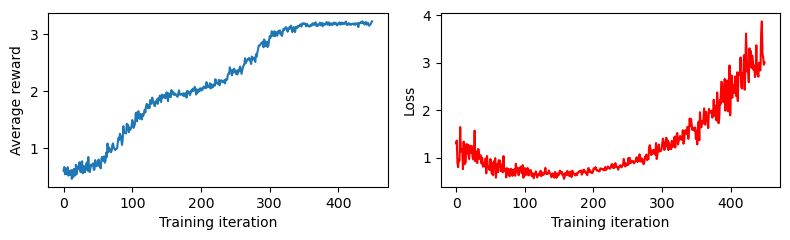

100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


Sample trajectories: 100
[7.879, 7.045, 5.621, 1.142, 0.338, 0.061]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S3)NC4=CC=C5OC(=NC5=C4)C=CC=C(Cl)C(Br)=C3
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.134, 8.572, 7.929, 3.306, 2.254, 2.003]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=C6C(Br)=C5C7C=CCC7[N+1]N6
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.853, 8.755, 7.718, 2.770, 2.588, 1.649]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC

[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[8.783, 8.733, 7.925, 2.639, 2.547, 1.997]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C=C5NC=NC6=CC=C(Br)S6OCCN=NC7=CC=CC=C7CCC8CC8
[5.663, 5.718, 5.253, 0.025, 0.028, 0.030]    O=CCOCCNCCNCN1C=C2C=C(CC=C2N1CC)S(=O)(=O)N3CCCCC3
[8.315, 7.998, 7.743, 1.810, 1.310, 1.690]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C6=CC(Br)=C5C=C6Br
[5.864, 5.890, 5.451, 0.037, 0.039, 0.044]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6OC=C

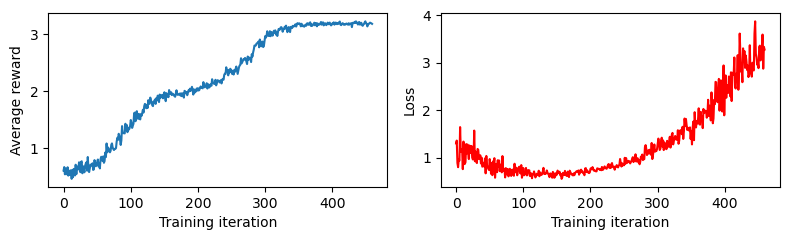

100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


Sample trajectories: 100
[9.482, 8.876, 7.888, 3.984, 2.813, 1.932]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Cl)=C5C6C=CCC6Cl
[5.705, 6.096, 5.723, 0.027, 0.059, 0.075]    CCNC(=O)C(CC)N(CC1=CC=CC=C1Cl)C(=O)CN(S(C)(=O)=O)C2=CC(=CC=C2C)C(=C)C(C)(C)C
[9.779, 9.123, 8.117, 4.568, 3.284, 2.336]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6NC7=CC=C(Cl)C=C7C(=O)C8=CC=CC=C8
[9.483, 8.690, 8.142, 3.984, 2.469, 2.381]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.029, 8.000, 7.216, 3.104, 1.313, 0.932]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])N

[8.418, 8.256, 7.700, 1.984, 1.711, 1.620]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5CCCCF
[8.178, 8.105, 7.678, 1.586, 1.472, 1.586]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6(CCOCCO)OCCOC=CC=CN=NC=CCNC7CCCC7
[8.222, 7.491, 7.146, 1.655, 0.684, 0.850]    O=C(C1=CC=C(F)C=C1)NC(=S)NC2=CC=C3OC(=NC3=C2)C=CC4=C(Br)C=CC(Br)=C4C5C=CCC5Cl
[8.049, 8.147, 6.241, 1.386, 1.537, 0.198]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6=C
[9.488, 8.806, 7.896, 3.994, 2.682, 1.945]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(F)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[6.632, 5.530, 5.589, 0.162, 0.019, 0.058]    O=CC=CCSC1=NN=C(N1C2=CC=CC=C2)CNC(=O)C3=CC=C(C(C)(C)C)C=C3CNCC4C=CC=CC5(N)C=

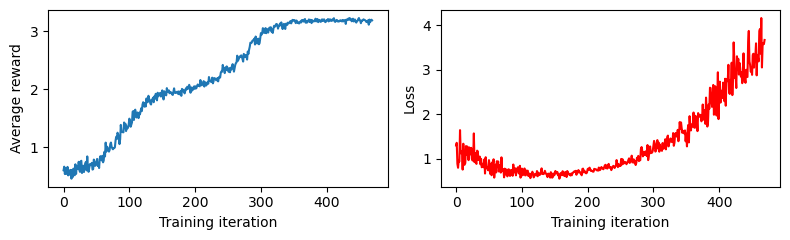

100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Sample trajectories: 100
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.931, 7.671, 6.918, 1.214, 0.879, 0.615]    O=CNCCSNC(=S)NC1=CC=C2OC(=NC2=C1)C=CC3=C(Br)C=CC(Br)=C3C4C=CCC4Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.345, 8.066, 7.033, 1.859, 1.411, 0.727]    O=C(C(=O)COC1=CC=CC2=C1)N3N=C4C(=CC5=CC=C(Cl)C=C5)CCCC4C3C6=CC=C(F)C=C6C2
[5.367, 5.285, 5.479, 0.014, 0.012, 0.047]    CC(C)(OCCO1)CCCCOCC2CCCN2C(C1)(C(=O)CNC(=O)C3=CC4=CO3)OC(=O)N4
[8.387, 9.053, 7.700, 1.930, 3.149, 1.621]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=CC(Br)=C5O
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CC

[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.840, 8.603, 7.964, 2.746, 2.310, 2.064]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5NC=NN=CBr
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.834, 8.577, 8.208, 2.735, 2.264, 2.502]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C6=CC(Br)=C5NC7CCCCC7CCOCCO6
[9.409, 9.419, 7.951, 3.839, 3.859, 2.041]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=CC=C(Br)C(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C

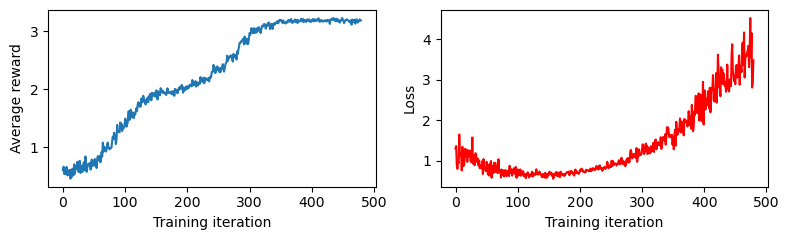

100%|██████████| 100/100 [00:05<00:00, 18.69it/s]


Sample trajectories: 100
[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.522, 8.807, 7.894, 2.166, 2.685, 1.943]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=

[7.084, 7.689, 7.202, 0.361, 0.900, 0.915]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C5=C6C=C(Br)C=C56
[7.263, 6.396, 6.443, 0.484, 0.104, 0.284]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6(C7=C8C=CC=C7Br)C=CSC=NC9=C%10C=CC=C9CCCCC%10C%11S%12C=NC=COC%13N=CNN=C(C8)CC%14=C%12C%11CCC%13(OC%15=CC=CC(Cl)=C%15)CN%14C=CCN=C(CCO)C(=O)OCCCCCS(=O)(=O)SC%16=CC=C%17C(=C%16)OCO%17
[9.407, 9.028, 8.228, 3.836, 3.103, 2.538]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Cl)C=CC(Br)=C5C6C=CCC6Cl
[9.240, 8.555, 7.034, 3.511, 2.224, 0.728]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=C(Br)C=CC(Br)CSCC(N5C(=O)C6=CC=CC=C6C5=O)(C7=CC=CC=C7OCC)NCSC=CCOC=CCCNC8C9C%10CC8%10C(=O)N=C9O
[7.669, 8.291, 6.956, 0.876, 1.769, 0.651]    O=C(C1=CC=C(N2CCCCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=C5C=CC=C(C5)C6=CC=C[NH1]6
[7.773, 7.462, 6.418, 1.002, 0.656, 0.

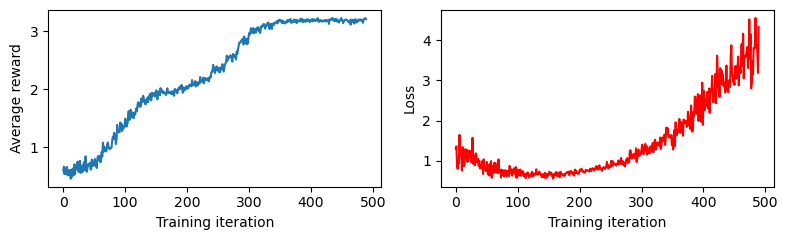

100%|██████████| 100/100 [00:06<00:00, 16.54it/s]


Sample trajectories: 100
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.339, 7.378, 6.984, 1.850, 0.578, 0.678]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C7=CCC6NC(Cl)=C7CC(C8=NN=NN8CC9C%10=C%11C=CC=C%10)C%11S9CC=CC%12=CC=CC=C%12NCC=C(C(=O)NCC%13=CC=CC=C%13)PC(=O)C%14=CC=C(Cl)C=C%14Cl
[8.315, 8.329, 7.654, 1.809, 1.832, 1.547]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6N=C7C=CC=C=N7
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(

[6.241, 6.961, 5.969, 0.078, 0.293, 0.120]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=CCCCCCNCN(CC)CC5=CC=CC=C5
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[5.581, 5.511, 5.386, 0.021, 0.019, 0.039]    CCN1C(CNC(=O)C2=CC=C(Cl)C(Cl)=C2)=NN=C1SCC(=O)NC3=CC(=CC=C3Cl)S(=O)(=O)N4CCCC4
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CC

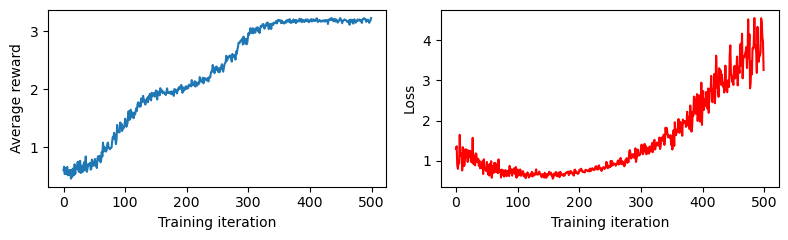

100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


Sample trajectories: 100
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.846, 8.512, 7.678, 2.758, 2.148, 1.586]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6SCC7=CC=C8C=C7CC9=CC=CC=C9CN%10C=CC=C%108
[7.348, 6.844, 6.519, 0.552, 0.238, 0.324]    O=C(C1=CC=C(N2CCOCC23)C(=C1)[N+1](=O)[O-1])NC(C(=O)NC)CC4=CC=C(C=C4)C5=NC6=CC(=CC=C6O5)OCC7=CC=C(F)C=C7CNCCNC3SCC(=O)NC8=CC=C(Br)C=C8F
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.401, 7.599, 7.155, 0.599, 0.797, 0.860]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C(C=C3)N4CCN(CC45)C=C(F)C(F)=C(F)C(F)=C5OC6=CC=CC=C6
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[5.649, 5.097

[6.933, 7.693, 6.349, 0.279, 0.904, 0.241]    O=CNC=CC1CN2C(=O)NC(C2=O)CC3=CC=C(C=C3)CCCNC=C(Cl)SNC4COC5=CC=C(Cl)C=C5C1C=C4C67OC(=CC=C6OC8C(N)=O)NCCCN(CC8)CCC7(C9=C(F)C(F)=C(F)C(F)=C9F)C%10=CC=CC=C%10O
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[8.230, 7.387, 7.190, 1.669, 0.587, 0.901]    O=CC=CC=CCCCNCCC1=CC=CC=C1C2SC=NCSCC3=CC=CC=C3NN=C2C=CC(F)=NC(F)C=CCOC4=CC=CC=C4
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6Cl
[7.166, 6.556, 6.509, 0.414, 0.141, 0.318]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC=C(Br)C=CC(C(=C)OCC)[N+1](=O)[O-1]
[9.483, 8.690, 8.142, 3.984, 2.469, 2.381]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](=O)[O-1])NC(=S)NC3=CC=C4OC(=NC4=C3)C=CC5=C(Br)C=CC(Br)=C5C6C=CCC6
[9.734, 8.974, 8.259, 4.479, 2.999, 2.596]    O=C(C1=CC=C(N2CCOCC2)C(=C1)[N+1](

In [22]:
tr_rewards = [] # rewards when training the model
rl_losses = [] # loss when training the model
reconst_losses = [] # reconstruction loss
entropy_losses = [] # entropy regularization

ba_A_list = []
ba_B_list = []
ba_C_list = []

execution_times = []

## Training RL optimizer
start_time = time.time()

alpha_min = 0.01
alpha_max = 0.1
alpha_inc = (alpha_max - alpha_min) / n_iterations
alpha = alpha_min
for i in range(1, n_iterations+1):
    ## policy gradient
    alpha += alpha_inc
    cur_reward, cur_loss, cur_reconst, cur_entropy = ReBADD.policy_gradient(n_batch=8, grad_clipping=1., alpha=alpha)
    
    ## append - reward
    #reward = simple_moving_average(tr_rewards, cur_reward)
    reward = cur_reward
    tr_rewards.append(reward)
    
    ## append - loss
    #rl_loss = simple_moving_average(rl_losses, cur_loss)
    rl_loss = cur_loss
    rl_losses.append(rl_loss)
    #reconst_loss = simple_moving_average(reconst_losses, cur_reconst)
    reconst_loss = cur_reconst
    reconst_losses.append(reconst_loss)
    #entropy_loss = simple_moving_average(entropy_losses, cur_entropy)
    entropy_loss = cur_entropy
    entropy_losses.append(entropy_loss)
        
    ## execution time check
    end_time = time.time()
    exec_time = end_time - start_time
    execution_times.append(exec_time)
    
    ## print - logs
    print(f"[{i:04d}] rl_loss: {rl_loss:.3f}\treconst_loss: {reconst_loss:.3f}\tentropy_loss: {entropy_loss:.3f}\treward: {reward:.3f}\ttau: {ReBADD.tau:.3f}\t({exec_time:.3f} sec)")
        
    ## checkpoint
    avg_ba_A = 0.
    avg_ba_B = 0.
    avg_ba_C = 0.
    if i % checkpoint_stepsize == 0:
        ## save
        ReBADD.generator.save_model(model_path.replace('.pth', f'.pth.{i:04d}'))
        
        ## plotting
        show_reward_loss(tr_rewards, rl_losses)

        ## sampling check
        smiles_cur = SMILES_generate(ReBADD, n_to_generate=100, gen_data=gen_data)
        print(f'Sample trajectories: {len(smiles_cur)}')
        if len(smiles_cur) > 0:
            for sm in smiles_cur:
                _, ba_A, ba_B, ba_C, score_A, score_B, score_C = my_reward_ft(sm, debug=True)
                print(f"[{ba_A:.3f}, {ba_B:.3f}, {ba_C:.3f}, {score_A:.3f}, {score_B:.3f}, {score_C:.3f}]    {sm}")
                avg_ba_A += ba_A
                avg_ba_B += ba_B
                avg_ba_C += ba_C
            avg_ba_A /= len(smiles_cur)
            avg_ba_B /= len(smiles_cur)
            avg_ba_C /= len(smiles_cur)
    
    ## append - binding affinity values
    ba_A_list.append(avg_ba_A)
    ba_B_list.append(avg_ba_B)
    ba_C_list.append(avg_ba_C)
    
    ## history save
    _ = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses, ba_A_list, ba_B_list, ba_C_list, execution_times, losses_path)
    
    if i % behavior_stepsize == 0:
        ReBADD.update_behavior()

# 3. Save

In [23]:
ReBADD.generator.save_model(model_path)

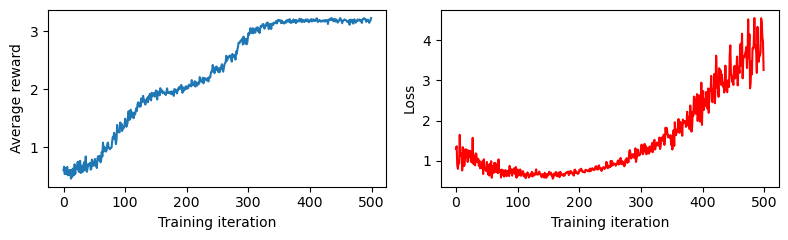

In [24]:
show_reward_loss(tr_rewards, rl_losses, filepath=plot_path)

In [25]:
df_history = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses, ba_A_list, ba_B_list, ba_C_list, execution_times, losses_path)
print(df_history.shape)
print(df_history.head())

(500, 8)
     REWARD      LOSS  LOSS_RECONST  LOSS_ENTROPY  BA_A  BA_B  BA_C  \
0  0.603911  1.300998      1.211846      0.089152   0.0   0.0   0.0   
1  0.664977  1.360385      1.268611      0.091775   0.0   0.0   0.0   
2  0.538437  0.888162      0.793425      0.094737   0.0   0.0   0.0   
3  0.638464  0.799933      0.702589      0.097344   0.0   0.0   0.0   
4  0.539319  0.964263      0.866242      0.098021   0.0   0.0   0.0   

    EXEC_TIME  
0   23.589927  
1   46.075829  
2   68.559752  
3   90.698347  
4  114.205662  


In [26]:
def save_smiles(filepath, smiles):
    with open(filepath, 'w') as fout:
        for smi in smiles:
            fout.write(f"{smi}\n")
    print(f"[INFO] {len(smiles)} SMILES were saved in {filepath}")

In [27]:
n_sampling = 30000

smi_after = SMILES_generate(ReBADD, n_sampling, gen_data)

100%|██████████| 30000/30000 [30:06<00:00, 16.61it/s]


In [28]:
save_smiles(os.path.join(dataconfigs.output_dir, "smi_after.csv"), smi_after)

[INFO] 30000 SMILES were saved in outputs_2_optimize_ReBADD/zinc15/smi_after.csv
